### Importing libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

### 1. Load the dataset

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
comp_pred = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('VariableDefinitions.csv')

In [3]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', comp_pred.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [4]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


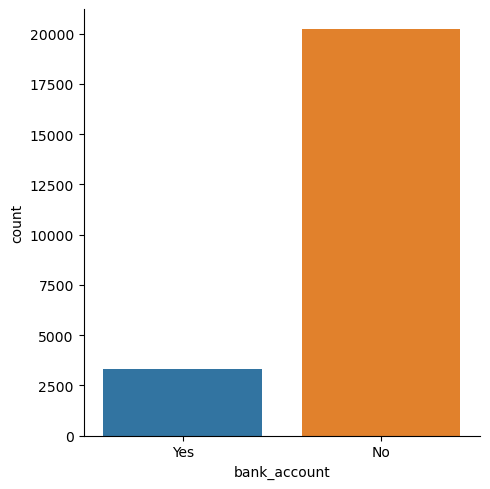

In [6]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

In [7]:
# view the submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [8]:
 #show some information about the dataset
 print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [9]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [10]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Cobvert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int32


In [11]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    return data                  

In [12]:
# preprocess the train data 
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(comp_pred)

In [13]:
# the first train row
print(processed_train[:1])

[[1.        0.        1.        0.1       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


In [14]:
# shape of the processed train set
print(processed_train.shape)

(23524, 37)


In [15]:
import sklearn.model_selection

In [16]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, 
                                                  test_size = 0.1, random_state=42)

### Autofeat uses AUC-ROC as scoring metric

In [17]:
from autofeat import AutoFeatClassifier, FeatureSelector

In [18]:
afc = AutoFeatClassifier(verbose=1,n_jobs=-1)

In [19]:
X_train_feat = afc.fit_transform(X_Train,y_Train)

[AutoFeat] The 2 step feature engineering process could generate up to 33670 features.
[AutoFeat] With 21171 data points this new feature matrix would use about 2.85 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 12 transformed features from 37 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 1034 feature combinations from 1176 original feature tuples - done.
[feateng] Generated altogether 1188 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 910 additional features
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 109.0min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 109.3min remaining: 164.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 110.8min remaining: 73.9min
[Parallel(n_jobs=-1)]

In [20]:
X_Val_feat = afc.transform(X_Val)

[AutoFeat] Computing 29 new features.
[AutoFeat]    29/   29 new features ...done.


In [21]:
lgbm = LGBMClassifier()

In [22]:
lgbm.fit(X_train_feat, y_Train)

LGBMClassifier()

In [23]:
y_pred_lgbm = lgbm.predict(X_Val_feat)

In [24]:
accuracy_lgbm = accuracy_score(y_val, y_pred_lgbm)
print("Accuracy (LightGBM):", 1-accuracy_lgbm)

Accuracy (LightGBM): 0.10667233319167024


In [25]:
comp_feat_V1 = afc.transform(processed_test)

[AutoFeat] Computing 29 new features.
[AutoFeat]    29/   29 new features ...done.


In [26]:
submission_V6_pred = lgbm.predict(comp_feat_V1)

In [27]:
submission_V6 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V6_pred})

In [28]:
submission_V6.sample(5)

,uniqueid,bank_account
8487,uniqueid_8762 x Tanzania,1
9016,uniqueid_9291 x Tanzania,0
8094,uniqueid_8369 x Tanzania,0
4688,uniqueid_10823 x Rwanda,0
6045,uniqueid_12180 x Rwanda,0


In [29]:
submission_V6.to_csv('V6_submission.csv', index = False)

V7 - Optuna & LGBM

In [67]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100)
    }
    # Train the model using the hyperparameters
    lgbm_optuna = LGBMClassifier(**params)
    lgbm_optuna.fit(X_train_feat, y_Train)

    # Make predictions on the validation set
    y_pred_lgbm_optuna = lgbm_optuna.predict(X_Val_feat)

    # Calculate the evaluation metric (e.g., accuracy)
    accuracy = accuracy_score(y_val, y_pred_lgbm_optuna)

    # Return the evaluation metric value
    return accuracy
    

In [68]:
study = optuna.create_study(direction='maximize')

[I 2023-07-16 23:58:10,380] A new study created in memory with name: no-name-6b0eb8a8-ec1f-4fc7-ac5d-0922dac6e69d


In [69]:
study.optimize(objective, n_trials=100)

[I 2023-07-16 23:58:17,547] Trial 0 finished with value: 0.8759031024224394 and parameters: {'lambda_l1': 7.556614681962757e-08, 'lambda_l2': 0.43249639366979725, 'num_leaves': 87, 'learning_rate': 0.02603426977468271, 'feature_fraction': 0.11872984593110177, 'bagging_fraction': 0.21359997002600822, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 0 with value: 0.8759031024224394.


[LightGBM] [Warning] feature_fraction is set=0.11872984593110177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11872984593110177
[LightGBM] [Warning] lambda_l1 is set=7.556614681962757e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.556614681962757e-08
[LightGBM] [Warning] bagging_fraction is set=0.21359997002600822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21359997002600822
[LightGBM] [Warning] lambda_l2 is set=0.43249639366979725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43249639366979725
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24720083633665574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24720083633665574
[LightGBM] [Warning] lambda_l1 is set=0.00013583441254154562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013583441254154562
[LightGBM] [War

[I 2023-07-16 23:58:18,267] Trial 1 finished with value: 0.888652783680408 and parameters: {'lambda_l1': 0.00013583441254154562, 'lambda_l2': 0.0032729014518176973, 'num_leaves': 229, 'learning_rate': 0.036883940992805196, 'feature_fraction': 0.24720083633665574, 'bagging_fraction': 0.7526814326869746, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 1 with value: 0.888652783680408.


[LightGBM] [Warning] feature_fraction is set=0.5690287249887854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690287249887854
[LightGBM] [Warning] lambda_l1 is set=3.684061091459924e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.684061091459924e-05
[LightGBM] [Warning] bagging_fraction is set=0.8698193170865084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8698193170865084
[LightGBM] [Warning] lambda_l2 is set=4.418729706130533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.418729706130533
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-07-16 23:58:18,730] Trial 2 finished with value: 0.8899277518062049 and parameters: {'lambda_l1': 3.684061091459924e-05, 'lambda_l2': 4.418729706130533, 'num_leaves': 350, 'learning_rate': 0.019578471474499544, 'feature_fraction': 0.5690287249887854, 'bagging_fraction': 0.8698193170865084, 'bagging_freq': 10, 'min_child_samples': 92}. Best is trial 2 with value: 0.8899277518062049.


[LightGBM] [Warning] feature_fraction is set=0.9669177991118608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9669177991118608
[LightGBM] [Warning] lambda_l1 is set=1.0191407089554636e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0191407089554636e-05
[LightGBM] [Warning] bagging_fraction is set=0.9176244730433161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176244730433161
[LightGBM] [Warning] lambda_l2 is set=0.16151271848392768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16151271848392768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:58:19,503] Trial 3 finished with value: 0.8869528261793456 and parameters: {'lambda_l1': 1.0191407089554636e-05, 'lambda_l2': 0.16151271848392768, 'num_leaves': 246, 'learning_rate': 0.013864655838706726, 'feature_fraction': 0.9669177991118608, 'bagging_fraction': 0.9176244730433161, 'bagging_freq': 1, 'min_child_samples': 71}. Best is trial 2 with value: 0.8899277518062049.


[LightGBM] [Warning] feature_fraction is set=0.7084977974220861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7084977974220861
[LightGBM] [Warning] lambda_l1 is set=2.2805581285572423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2805581285572423
[LightGBM] [Warning] bagging_fraction is set=0.15155889442705617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15155889442705617
[LightGBM] [Warning] lambda_l2 is set=0.17930758272083228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17930758272083228
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-16 23:58:19,765] Trial 4 finished with value: 0.8865278368040799 and parameters: {'lambda_l1': 2.2805581285572423, 'lambda_l2': 0.17930758272083228, 'num_leaves': 445, 'learning_rate': 0.024633271765959027, 'feature_fraction': 0.7084977974220861, 'bagging_fraction': 0.15155889442705617, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 2 with value: 0.8899277518062049.


[LightGBM] [Warning] feature_fraction is set=0.4680167098670521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4680167098670521
[LightGBM] [Warning] lambda_l1 is set=0.00042177335097586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00042177335097586
[LightGBM] [Warning] bagging_fraction is set=0.859023385589637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859023385589637
[LightGBM] [Warning] lambda_l2 is set=1.6937399505843802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6937399505843802
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-07-16 23:58:20,388] Trial 5 finished with value: 0.8839779005524862 and parameters: {'lambda_l1': 0.00042177335097586, 'lambda_l2': 1.6937399505843802, 'num_leaves': 360, 'learning_rate': 0.014021935906331558, 'feature_fraction': 0.4680167098670521, 'bagging_fraction': 0.859023385589637, 'bagging_freq': 8, 'min_child_samples': 60}. Best is trial 2 with value: 0.8899277518062049.


[LightGBM] [Warning] feature_fraction is set=0.5774460091830584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774460091830584
[LightGBM] [Warning] lambda_l1 is set=0.011394395100983562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011394395100983562
[LightGBM] [Warning] bagging_fraction is set=0.43430835727604267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43430835727604267
[LightGBM] [Warning] lambda_l2 is set=0.08915557826298581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08915557826298581
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:58:20,815] Trial 6 finished with value: 0.8844028899277518 and parameters: {'lambda_l1': 0.011394395100983562, 'lambda_l2': 0.08915557826298581, 'num_leaves': 351, 'learning_rate': 0.014188406024300741, 'feature_fraction': 0.5774460091830584, 'bagging_fraction': 0.43430835727604267, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 2 with value: 0.8899277518062049.


[LightGBM] [Warning] feature_fraction is set=0.2185100337298797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2185100337298797
[LightGBM] [Warning] lambda_l1 is set=0.025313779883088753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025313779883088753
[LightGBM] [Warning] bagging_fraction is set=0.8299018643376249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8299018643376249
[LightGBM] [Warning] lambda_l2 is set=1.2901156000949876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2901156000949876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-16 23:58:21,199] Trial 7 finished with value: 0.8733531661708457 and parameters: {'lambda_l1': 0.025313779883088753, 'lambda_l2': 1.2901156000949876, 'num_leaves': 26, 'learning_rate': 0.01344859809970561, 'feature_fraction': 0.2185100337298797, 'bagging_fraction': 0.8299018643376249, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 2 with value: 0.8899277518062049.


[LightGBM] [Warning] feature_fraction is set=0.7818157218541556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7818157218541556
[LightGBM] [Warning] lambda_l1 is set=1.3878690369562588e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3878690369562588e-08
[LightGBM] [Warning] bagging_fraction is set=0.999147347220967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999147347220967
[LightGBM] [Warning] lambda_l2 is set=8.865408680577424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.865408680577424
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-16 23:58:21,825] Trial 8 finished with value: 0.8903527411814705 and parameters: {'lambda_l1': 1.3878690369562588e-08, 'lambda_l2': 8.865408680577424, 'num_leaves': 99, 'learning_rate': 0.05977227112175632, 'feature_fraction': 0.7818157218541556, 'bagging_fraction': 0.999147347220967, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 8 with value: 0.8903527411814705.


[LightGBM] [Warning] feature_fraction is set=0.13325810779870684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13325810779870684
[LightGBM] [Warning] lambda_l1 is set=2.2938903304361347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2938903304361347
[LightGBM] [Warning] bagging_fraction is set=0.23870747851024146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23870747851024146
[LightGBM] [Warning] lambda_l2 is set=1.9031408445730788e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9031408445730788e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:22,137] Trial 9 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 2.2938903304361347, 'lambda_l2': 1.9031408445730788e-07, 'num_leaves': 78, 'learning_rate': 0.07810195887227517, 'feature_fraction': 0.13325810779870684, 'bagging_fraction': 0.23870747851024146, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 8 with value: 0.8903527411814705.


[LightGBM] [Warning] feature_fraction is set=0.9392334298469103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9392334298469103
[LightGBM] [Warning] lambda_l1 is set=2.5244137007184323e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5244137007184323e-08
[LightGBM] [Warning] bagging_fraction is set=0.9915696338512924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915696338512924
[LightGBM] [Warning] lambda_l2 is set=8.854598885953607e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.854598885953607e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-07-16 23:58:22,979] Trial 10 finished with value: 0.8844028899277518 and parameters: {'lambda_l1': 2.5244137007184323e-08, 'lambda_l2': 8.854598885953607e-05, 'num_leaves': 164, 'learning_rate': 0.08616105192242365, 'feature_fraction': 0.9392334298469103, 'bagging_fraction': 0.9915696338512924, 'bagging_freq': 10, 'min_child_samples': 6}. Best is trial 8 with value: 0.8903527411814705.


[LightGBM] [Warning] feature_fraction is set=0.7476837019487982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7476837019487982
[LightGBM] [Warning] lambda_l1 is set=9.28477478886704e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.28477478886704e-07
[LightGBM] [Warning] bagging_fraction is set=0.7011875824289722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7011875824289722
[LightGBM] [Warning] lambda_l2 is set=5.438058680050203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.438058680050203
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-07-16 23:58:23,620] Trial 11 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 9.28477478886704e-07, 'lambda_l2': 5.438058680050203, 'num_leaves': 348, 'learning_rate': 0.048924730271658355, 'feature_fraction': 0.7476837019487982, 'bagging_fraction': 0.7011875824289722, 'bagging_freq': 10, 'min_child_samples': 86}. Best is trial 8 with value: 0.8903527411814705.


[LightGBM] [Warning] feature_fraction is set=0.4783544278644303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4783544278644303
[LightGBM] [Warning] lambda_l1 is set=1.5125772916325807e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5125772916325807e-08
[LightGBM] [Warning] bagging_fraction is set=0.9574345403424578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9574345403424578
[LightGBM] [Warning] lambda_l2 is set=7.044623021860235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.044623021860235
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-07-16 23:58:24,482] Trial 12 finished with value: 0.8882277943051424 and parameters: {'lambda_l1': 1.5125772916325807e-08, 'lambda_l2': 7.044623021860235, 'num_leaves': 483, 'learning_rate': 0.055813383622295466, 'feature_fraction': 0.4783544278644303, 'bagging_fraction': 0.9574345403424578, 'bagging_freq': 9, 'min_child_samples': 42}. Best is trial 8 with value: 0.8903527411814705.


[LightGBM] [Warning] feature_fraction is set=0.7879904401917582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7879904401917582
[LightGBM] [Warning] lambda_l1 is set=9.86376627623271e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.86376627623271e-07
[LightGBM] [Warning] bagging_fraction is set=0.6465264777247131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6465264777247131
[LightGBM] [Warning] lambda_l2 is set=0.005762131427047881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005762131427047881
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:25,326] Trial 13 finished with value: 0.8924776880577986 and parameters: {'lambda_l1': 9.86376627623271e-07, 'lambda_l2': 0.005762131427047881, 'num_leaves': 162, 'learning_rate': 0.03433287566661186, 'feature_fraction': 0.7879904401917582, 'bagging_fraction': 0.6465264777247131, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 13 with value: 0.8924776880577986.


[LightGBM] [Warning] feature_fraction is set=0.8257699340981767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8257699340981767
[LightGBM] [Warning] lambda_l1 is set=9.808201565528659e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.808201565528659e-07
[LightGBM] [Warning] bagging_fraction is set=0.610299940843538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.610299940843538
[LightGBM] [Warning] lambda_l2 is set=0.006014183499338371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006014183499338371
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:25,999] Trial 14 finished with value: 0.8924776880577986 and parameters: {'lambda_l1': 9.808201565528659e-07, 'lambda_l2': 0.006014183499338371, 'num_leaves': 154, 'learning_rate': 0.03882171586011346, 'feature_fraction': 0.8257699340981767, 'bagging_fraction': 0.610299940843538, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 13 with value: 0.8924776880577986.


[LightGBM] [Warning] feature_fraction is set=0.8643404026770953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8643404026770953
[LightGBM] [Warning] lambda_l1 is set=1.4786644437634732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4786644437634732e-06
[LightGBM] [Warning] bagging_fraction is set=0.5902670365601201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5902670365601201
[LightGBM] [Warning] lambda_l2 is set=0.0031361074120335084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031361074120335084
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:58:26,588] Trial 15 finished with value: 0.8946026349341266 and parameters: {'lambda_l1': 1.4786644437634732e-06, 'lambda_l2': 0.0031361074120335084, 'num_leaves': 177, 'learning_rate': 0.03693737415417789, 'feature_fraction': 0.8643404026770953, 'bagging_fraction': 0.5902670365601201, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8790137470451245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8790137470451245
[LightGBM] [Warning] lambda_l1 is set=9.018597643609056e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.018597643609056e-07
[LightGBM] [Warning] bagging_fraction is set=0.5015289115132359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015289115132359
[LightGBM] [Warning] lambda_l2 is set=7.683042456827204e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.683042456827204e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:58:27,100] Trial 16 finished with value: 0.8895027624309392 and parameters: {'lambda_l1': 9.018597643609056e-07, 'lambda_l2': 7.683042456827204e-05, 'num_leaves': 186, 'learning_rate': 0.03346382558760217, 'feature_fraction': 0.8790137470451245, 'bagging_fraction': 0.5015289115132359, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9911595866135623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9911595866135623
[LightGBM] [Warning] lambda_l1 is set=6.767127125017375e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.767127125017375e-06
[LightGBM] [Warning] bagging_fraction is set=0.6061605941358438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061605941358438
[LightGBM] [Warning] lambda_l2 is set=0.0008801127163662823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008801127163662823
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:28,648] Trial 17 finished with value: 0.8848278793030174 and parameters: {'lambda_l1': 6.767127125017375e-06, 'lambda_l2': 0.0008801127163662823, 'num_leaves': 284, 'learning_rate': 0.044572214136442044, 'feature_fraction': 0.9911595866135623, 'bagging_fraction': 0.6061605941358438, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.683144435675108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.683144435675108
[LightGBM] [Warning] lambda_l1 is set=3.0969477516519676e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0969477516519676e-07
[LightGBM] [Warning] bagging_fraction is set=0.41431685574280663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41431685574280663
[LightGBM] [Warning] lambda_l2 is set=0.019971224282204044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019971224282204044
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:58:29,004] Trial 18 finished with value: 0.8903527411814705 and parameters: {'lambda_l1': 3.0969477516519676e-07, 'lambda_l2': 0.019971224282204044, 'num_leaves': 15, 'learning_rate': 0.028371293709526936, 'feature_fraction': 0.683144435675108, 'bagging_fraction': 0.41431685574280663, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.841220762839661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.841220762839661
[LightGBM] [Warning] lambda_l1 is set=2.3279644286611517e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3279644286611517e-07
[LightGBM] [Warning] bagging_fraction is set=0.7415248434792208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415248434792208
[LightGBM] [Warning] lambda_l2 is set=0.0003460348121948229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003460348121948229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:58:30,203] Trial 19 finished with value: 0.885252868678283 and parameters: {'lambda_l1': 2.3279644286611517e-07, 'lambda_l2': 0.0003460348121948229, 'num_leaves': 204, 'learning_rate': 0.01984335393200671, 'feature_fraction': 0.841220762839661, 'bagging_fraction': 0.7415248434792208, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.891085319080548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.891085319080548
[LightGBM] [Warning] lambda_l1 is set=2.0069958551690054e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0069958551690054e-06
[LightGBM] [Warning] bagging_fraction is set=0.6534836400878451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6534836400878451
[LightGBM] [Warning] lambda_l2 is set=1.8509703009747996e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8509703009747996e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:58:31,098] Trial 20 finished with value: 0.8920526986825329 and parameters: {'lambda_l1': 2.0069958551690054e-06, 'lambda_l2': 1.8509703009747996e-05, 'num_leaves': 295, 'learning_rate': 0.034295596479163255, 'feature_fraction': 0.891085319080548, 'bagging_fraction': 0.6534836400878451, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8248182706918604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8248182706918604
[LightGBM] [Warning] lambda_l1 is set=1.3941442789602178e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3941442789602178e-07
[LightGBM] [Warning] bagging_fraction is set=0.5757080970795462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5757080970795462
[LightGBM] [Warning] lambda_l2 is set=0.009393430088186976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009393430088186976
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:31,766] Trial 21 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 1.3941442789602178e-07, 'lambda_l2': 0.009393430088186976, 'num_leaves': 141, 'learning_rate': 0.04065198497281233, 'feature_fraction': 0.8248182706918604, 'bagging_fraction': 0.5757080970795462, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8744931407126443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8744931407126443
[LightGBM] [Warning] lambda_l1 is set=3.913054317445397e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.913054317445397e-06
[LightGBM] [Warning] bagging_fraction is set=0.6296159306586632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6296159306586632
[LightGBM] [Warning] lambda_l2 is set=0.0023789946537678265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023789946537678265
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:32,356] Trial 22 finished with value: 0.8916277093072673 and parameters: {'lambda_l1': 3.913054317445397e-06, 'lambda_l2': 0.0023789946537678265, 'num_leaves': 129, 'learning_rate': 0.04162485753147987, 'feature_fraction': 0.8744931407126443, 'bagging_fraction': 0.6296159306586632, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.7914381127618911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7914381127618911
[LightGBM] [Warning] lambda_l1 is set=5.746791990779102e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.746791990779102e-07
[LightGBM] [Warning] bagging_fraction is set=0.5295577978712342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5295577978712342
[LightGBM] [Warning] lambda_l2 is set=0.01624204132159139, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01624204132159139
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:58:32,999] Trial 23 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 5.746791990779102e-07, 'lambda_l2': 0.01624204132159139, 'num_leaves': 184, 'learning_rate': 0.03167120666586155, 'feature_fraction': 0.7914381127618911, 'bagging_fraction': 0.5295577978712342, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.690102364923044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.690102364923044
[LightGBM] [Warning] lambda_l1 is set=1.2471895664586412e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2471895664586412e-05
[LightGBM] [Warning] bagging_fraction is set=0.674729990666692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.674729990666692
[LightGBM] [Warning] lambda_l2 is set=0.03504249232277277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03504249232277277
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:58:33,827] Trial 24 finished with value: 0.8878028049298767 and parameters: {'lambda_l1': 1.2471895664586412e-05, 'lambda_l2': 0.03504249232277277, 'num_leaves': 119, 'learning_rate': 0.05082517964582401, 'feature_fraction': 0.690102364923044, 'bagging_fraction': 0.674729990666692, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9246279835790944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9246279835790944
[LightGBM] [Warning] lambda_l1 is set=8.431205237326588e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.431205237326588e-08
[LightGBM] [Warning] bagging_fraction is set=0.7646277572815686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7646277572815686
[LightGBM] [Warning] lambda_l2 is set=0.0016490473810141077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016490473810141077
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:34,804] Trial 25 finished with value: 0.8895027624309392 and parameters: {'lambda_l1': 8.431205237326588e-08, 'lambda_l2': 0.0016490473810141077, 'num_leaves': 218, 'learning_rate': 0.03718495948689044, 'feature_fraction': 0.9246279835790944, 'bagging_fraction': 0.7646277572815686, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9873654781391338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9873654781391338
[LightGBM] [Warning] lambda_l1 is set=1.5534476320792838e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5534476320792838e-06
[LightGBM] [Warning] bagging_fraction is set=0.576080633707027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.576080633707027
[LightGBM] [Warning] lambda_l2 is set=0.006553299003221003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006553299003221003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:58:35,418] Trial 26 finished with value: 0.8937526561835955 and parameters: {'lambda_l1': 1.5534476320792838e-06, 'lambda_l2': 0.006553299003221003, 'num_leaves': 58, 'learning_rate': 0.06510699825379113, 'feature_fraction': 0.9873654781391338, 'bagging_fraction': 0.576080633707027, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9946680438108817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9946680438108817
[LightGBM] [Warning] lambda_l1 is set=2.328991442652297e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.328991442652297e-06
[LightGBM] [Warning] bagging_fraction is set=0.4982923824427549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4982923824427549
[LightGBM] [Warning] lambda_l2 is set=0.03248716871734172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03248716871734172
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:58:36,000] Trial 27 finished with value: 0.8895027624309392 and parameters: {'lambda_l1': 2.328991442652297e-06, 'lambda_l2': 0.03248716871734172, 'num_leaves': 50, 'learning_rate': 0.06024494990495478, 'feature_fraction': 0.9946680438108817, 'bagging_fraction': 0.4982923824427549, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9238586491194424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9238586491194424
[LightGBM] [Warning] lambda_l1 is set=2.0153219417288902e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0153219417288902e-05
[LightGBM] [Warning] bagging_fraction is set=0.5637310617444947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5637310617444947
[LightGBM] [Warning] lambda_l2 is set=0.0005076864385029598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005076864385029598
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:58:36,606] Trial 28 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 2.0153219417288902e-05, 'lambda_l2': 0.0005076864385029598, 'num_leaves': 57, 'learning_rate': 0.08130207167678907, 'feature_fraction': 0.9238586491194424, 'bagging_fraction': 0.5637310617444947, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9128488723752655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9128488723752655
[LightGBM] [Warning] lambda_l1 is set=6.866523986041565e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.866523986041565e-08
[LightGBM] [Warning] bagging_fraction is set=0.6808692678925403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6808692678925403
[LightGBM] [Warning] lambda_l2 is set=0.27306648417375956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27306648417375956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:58:37,340] Trial 29 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 6.866523986041565e-08, 'lambda_l2': 0.27306648417375956, 'num_leaves': 94, 'learning_rate': 0.06829130540546018, 'feature_fraction': 0.9128488723752655, 'bagging_fraction': 0.6808692678925403, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9950706216158771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9950706216158771
[LightGBM] [Warning] lambda_l1 is set=6.714591851645644e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.714591851645644e-08
[LightGBM] [Warning] bagging_fraction is set=0.4402024417947915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4402024417947915
[LightGBM] [Warning] lambda_l2 is set=0.004793616891394001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004793616891394001
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:58:38,155] Trial 30 finished with value: 0.8869528261793456 and parameters: {'lambda_l1': 6.714591851645644e-08, 'lambda_l2': 0.004793616891394001, 'num_leaves': 268, 'learning_rate': 0.09515204135437905, 'feature_fraction': 0.9950706216158771, 'bagging_fraction': 0.4402024417947915, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8345548869638952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8345548869638952
[LightGBM] [Warning] lambda_l1 is set=3.7366710660848215e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7366710660848215e-06
[LightGBM] [Warning] bagging_fraction is set=0.6045268806892016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6045268806892016
[LightGBM] [Warning] lambda_l2 is set=0.006276119581008937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006276119581008937
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:39,057] Trial 31 finished with value: 0.8929026774330642 and parameters: {'lambda_l1': 3.7366710660848215e-06, 'lambda_l2': 0.006276119581008937, 'num_leaves': 165, 'learning_rate': 0.044113683298126434, 'feature_fraction': 0.8345548869638952, 'bagging_fraction': 0.6045268806892016, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8522625943922005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8522625943922005
[LightGBM] [Warning] lambda_l1 is set=3.4470036041799027e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4470036041799027e-06
[LightGBM] [Warning] bagging_fraction is set=0.5595006279636044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595006279636044
[LightGBM] [Warning] lambda_l2 is set=0.0024483056309477272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024483056309477272
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:39,877] Trial 32 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 3.4470036041799027e-06, 'lambda_l2': 0.0024483056309477272, 'num_leaves': 171, 'learning_rate': 0.04275256926336965, 'feature_fraction': 0.8522625943922005, 'bagging_fraction': 0.5595006279636044, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.7687409858049927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7687409858049927
[LightGBM] [Warning] lambda_l1 is set=4.932162405684892e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932162405684892e-05
[LightGBM] [Warning] bagging_fraction is set=0.7171057918205359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7171057918205359
[LightGBM] [Warning] lambda_l2 is set=0.0836654413475229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0836654413475229
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:58:40,810] Trial 33 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 4.932162405684892e-05, 'lambda_l2': 0.0836654413475229, 'num_leaves': 238, 'learning_rate': 0.05127983852891035, 'feature_fraction': 0.7687409858049927, 'bagging_fraction': 0.7171057918205359, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9120982925664252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9120982925664252
[LightGBM] [Warning] lambda_l1 is set=2.6667551403782117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6667551403782117e-07
[LightGBM] [Warning] bagging_fraction is set=0.7792587976336627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792587976336627
[LightGBM] [Warning] lambda_l2 is set=0.008009540093012512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008009540093012512
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:58:41,687] Trial 34 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 2.6667551403782117e-07, 'lambda_l2': 0.008009540093012512, 'num_leaves': 120, 'learning_rate': 0.04588588248906656, 'feature_fraction': 0.9120982925664252, 'bagging_fraction': 0.7792587976336627, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.950651841348388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.950651841348388
[LightGBM] [Warning] lambda_l1 is set=3.87806325776371e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.87806325776371e-05
[LightGBM] [Warning] bagging_fraction is set=0.6312631234313523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6312631234313523
[LightGBM] [Warning] lambda_l2 is set=0.5218046506681405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5218046506681405
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:42,487] Trial 35 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 3.87806325776371e-05, 'lambda_l2': 0.5218046506681405, 'num_leaves': 221, 'learning_rate': 0.027973613234374698, 'feature_fraction': 0.950651841348388, 'bagging_fraction': 0.6312631234313523, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8642019824843504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8642019824843504
[LightGBM] [Warning] lambda_l1 is set=7.764813869504419e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.764813869504419e-06
[LightGBM] [Warning] bagging_fraction is set=0.6679127225799553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6679127225799553
[LightGBM] [Warning] lambda_l2 is set=0.040622409629485615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040622409629485615
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:58:43,145] Trial 36 finished with value: 0.8899277518062049 and parameters: {'lambda_l1': 7.764813869504419e-06, 'lambda_l2': 0.040622409629485615, 'num_leaves': 67, 'learning_rate': 0.06928888107895739, 'feature_fraction': 0.8642019824843504, 'bagging_fraction': 0.6679127225799553, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9583418510641082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9583418510641082
[LightGBM] [Warning] lambda_l1 is set=7.744329405636747e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.744329405636747e-05
[LightGBM] [Warning] bagging_fraction is set=0.8136675299676663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8136675299676663
[LightGBM] [Warning] lambda_l2 is set=0.0010523482265992648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010523482265992648
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:44,366] Trial 37 finished with value: 0.8929026774330642 and parameters: {'lambda_l1': 7.744329405636747e-05, 'lambda_l2': 0.0010523482265992648, 'num_leaves': 202, 'learning_rate': 0.036217967631409206, 'feature_fraction': 0.9583418510641082, 'bagging_fraction': 0.8136675299676663, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9653766914014886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9653766914014886
[LightGBM] [Warning] lambda_l1 is set=0.00019970023756197628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019970023756197628
[LightGBM] [Warning] bagging_fraction is set=0.7917409373622843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917409373622843
[LightGBM] [Warning] lambda_l2 is set=0.001079262145523159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001079262145523159
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:58:45,537] Trial 38 finished with value: 0.8933276668083298 and parameters: {'lambda_l1': 0.00019970023756197628, 'lambda_l2': 0.001079262145523159, 'num_leaves': 260, 'learning_rate': 0.03663613086658537, 'feature_fraction': 0.9653766914014886, 'bagging_fraction': 0.7917409373622843, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9574518004245396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9574518004245396
[LightGBM] [Warning] lambda_l1 is set=0.00040815939086641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040815939086641
[LightGBM] [Warning] bagging_fraction is set=0.8916511500513614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8916511500513614
[LightGBM] [Warning] lambda_l2 is set=0.00021511466174765022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021511466174765022
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:58:46,920] Trial 39 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 0.00040815939086641, 'lambda_l2': 0.00021511466174765022, 'num_leaves': 312, 'learning_rate': 0.029742072981719506, 'feature_fraction': 0.9574518004245396, 'bagging_fraction': 0.8916511500513614, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.7296042254647792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7296042254647792
[LightGBM] [Warning] lambda_l1 is set=0.00012328519946739702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012328519946739702
[LightGBM] [Warning] bagging_fraction is set=0.805793289742604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.805793289742604
[LightGBM] [Warning] lambda_l2 is set=0.10758285633699693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10758285633699693
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-07-16 23:58:48,304] Trial 40 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 0.00012328519946739702, 'lambda_l2': 0.10758285633699693, 'num_leaves': 320, 'learning_rate': 0.025234146196206505, 'feature_fraction': 0.7296042254647792, 'bagging_fraction': 0.805793289742604, 'bagging_freq': 8, 'min_child_samples': 68}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9384540504258636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9384540504258636
[LightGBM] [Warning] lambda_l1 is set=9.313766110575641e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.313766110575641e-05
[LightGBM] [Warning] bagging_fraction is set=0.8556138788887913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556138788887913
[LightGBM] [Warning] lambda_l2 is set=0.002198695717542328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002198695717542328
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:49,307] Trial 41 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 9.313766110575641e-05, 'lambda_l2': 0.002198695717542328, 'num_leaves': 246, 'learning_rate': 0.036568766369632646, 'feature_fraction': 0.9384540504258636, 'bagging_fraction': 0.8556138788887913, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9665207070077766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9665207070077766
[LightGBM] [Warning] lambda_l1 is set=0.0003562296038007646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003562296038007646
[LightGBM] [Warning] bagging_fraction is set=0.8200977434851268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200977434851268
[LightGBM] [Warning] lambda_l2 is set=0.0012705821812508857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012705821812508857
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:58:50,343] Trial 42 finished with value: 0.8865278368040799 and parameters: {'lambda_l1': 0.0003562296038007646, 'lambda_l2': 0.0012705821812508857, 'num_leaves': 200, 'learning_rate': 0.045038698408422485, 'feature_fraction': 0.9665207070077766, 'bagging_fraction': 0.8200977434851268, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8941382648526502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8941382648526502
[LightGBM] [Warning] lambda_l1 is set=0.0012680650221066321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012680650221066321
[LightGBM] [Warning] bagging_fraction is set=0.7306852533006073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7306852533006073
[LightGBM] [Warning] lambda_l2 is set=0.0007477998409826268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007477998409826268
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:51,257] Trial 43 finished with value: 0.8916277093072673 and parameters: {'lambda_l1': 0.0012680650221066321, 'lambda_l2': 0.0007477998409826268, 'num_leaves': 392, 'learning_rate': 0.039754032694815644, 'feature_fraction': 0.8941382648526502, 'bagging_fraction': 0.7306852533006073, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.966248188613744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.966248188613744
[LightGBM] [Warning] lambda_l1 is set=2.6823412959679026e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6823412959679026e-05
[LightGBM] [Warning] bagging_fraction is set=0.9135542615430265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9135542615430265
[LightGBM] [Warning] lambda_l2 is set=0.016162021290772547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016162021290772547
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-16 23:58:52,349] Trial 44 finished with value: 0.8899277518062049 and parameters: {'lambda_l1': 2.6823412959679026e-05, 'lambda_l2': 0.016162021290772547, 'num_leaves': 263, 'learning_rate': 0.031716121281882156, 'feature_fraction': 0.966248188613744, 'bagging_fraction': 0.9135542615430265, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9886413234525673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9886413234525673
[LightGBM] [Warning] lambda_l1 is set=1.2058830342684739e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2058830342684739e-05
[LightGBM] [Warning] bagging_fraction is set=0.7842807610665052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7842807610665052
[LightGBM] [Warning] lambda_l2 is set=0.0035268231051231065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0035268231051231065
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-07-16 23:58:53,202] Trial 45 finished with value: 0.8878028049298767 and parameters: {'lambda_l1': 1.2058830342684739e-05, 'lambda_l2': 0.0035268231051231065, 'num_leaves': 109, 'learning_rate': 0.05396120144671667, 'feature_fraction': 0.9886413234525673, 'bagging_fraction': 0.7842807610665052, 'bagging_freq': 8, 'min_child_samples': 95}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8181470924279635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8181470924279635
[LightGBM] [Warning] lambda_l1 is set=5.369886120756553e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.369886120756553e-05
[LightGBM] [Warning] bagging_fraction is set=0.7125349105530072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7125349105530072
[LightGBM] [Warning] lambda_l2 is set=0.0011772624801638868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011772624801638868
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:58:54,105] Trial 46 finished with value: 0.8882277943051424 and parameters: {'lambda_l1': 5.369886120756553e-05, 'lambda_l2': 0.0011772624801638868, 'num_leaves': 141, 'learning_rate': 0.04760518330356973, 'feature_fraction': 0.8181470924279635, 'bagging_fraction': 0.7125349105530072, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.88387518337974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.88387518337974
[LightGBM] [Warning] lambda_l1 is set=0.00020069794193254285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020069794193254285
[LightGBM] [Warning] bagging_fraction is set=0.8341581095897155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8341581095897155
[LightGBM] [Warning] lambda_l2 is set=0.00017329177019218797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017329177019218797
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:58:55,125] Trial 47 finished with value: 0.8895027624309392 and parameters: {'lambda_l1': 0.00020069794193254285, 'lambda_l2': 0.00017329177019218797, 'num_leaves': 201, 'learning_rate': 0.03556237694068078, 'feature_fraction': 0.88387518337974, 'bagging_fraction': 0.8341581095897155, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.941714242056575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941714242056575
[LightGBM] [Warning] lambda_l1 is set=6.091233358643115e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.091233358643115e-06
[LightGBM] [Warning] bagging_fraction is set=0.7425202050343293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7425202050343293
[LightGBM] [Warning] lambda_l2 is set=0.0005724725764462207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005724725764462207
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:58:56,270] Trial 48 finished with value: 0.8895027624309392 and parameters: {'lambda_l1': 6.091233358643115e-06, 'lambda_l2': 0.0005724725764462207, 'num_leaves': 230, 'learning_rate': 0.03826577301885382, 'feature_fraction': 0.941714242056575, 'bagging_fraction': 0.7425202050343293, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8445266177625164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8445266177625164
[LightGBM] [Warning] lambda_l1 is set=1.7433106199730586e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7433106199730586e-05
[LightGBM] [Warning] bagging_fraction is set=0.8663882877322083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8663882877322083
[LightGBM] [Warning] lambda_l2 is set=0.0082965955274654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0082965955274654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:58:57,738] Trial 49 finished with value: 0.8869528261793456 and parameters: {'lambda_l1': 1.7433106199730586e-05, 'lambda_l2': 0.0082965955274654, 'num_leaves': 394, 'learning_rate': 0.022624505312561688, 'feature_fraction': 0.8445266177625164, 'bagging_fraction': 0.8663882877322083, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9990406067241122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9990406067241122
[LightGBM] [Warning] lambda_l1 is set=3.0342156572866233e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0342156572866233e-06
[LightGBM] [Warning] bagging_fraction is set=0.593804616680263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.593804616680263
[LightGBM] [Warning] lambda_l2 is set=6.719019676066329e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.719019676066329e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:58,184] Trial 50 finished with value: 0.8929026774330642 and parameters: {'lambda_l1': 3.0342156572866233e-06, 'lambda_l2': 6.719019676066329e-05, 'num_leaves': 30, 'learning_rate': 0.057412825550746505, 'feature_fraction': 0.9990406067241122, 'bagging_fraction': 0.593804616680263, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.99645829552383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.99645829552383
[LightGBM] [Warning] lambda_l1 is set=1.9857780209698544e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9857780209698544e-06
[LightGBM] [Warning] bagging_fraction is set=0.5965778609550729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5965778609550729
[LightGBM] [Warning] lambda_l2 is set=5.797405760384504e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.797405760384504e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:58:58,670] Trial 51 finished with value: 0.894177645558861 and parameters: {'lambda_l1': 1.9857780209698544e-06, 'lambda_l2': 5.797405760384504e-05, 'num_leaves': 37, 'learning_rate': 0.05802854095939347, 'feature_fraction': 0.99645829552383, 'bagging_fraction': 0.5965778609550729, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9099773861287866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9099773861287866
[LightGBM] [Warning] lambda_l1 is set=1.4218632462824427e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4218632462824427e-06
[LightGBM] [Warning] bagging_fraction is set=0.6925039503921988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6925039503921988
[LightGBM] [Warning] lambda_l2 is set=3.158219142385379e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.158219142385379e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:58:59,357] Trial 52 finished with value: 0.8878028049298767 and parameters: {'lambda_l1': 1.4218632462824427e-06, 'lambda_l2': 3.158219142385379e-05, 'num_leaves': 80, 'learning_rate': 0.04878334028223426, 'feature_fraction': 0.9099773861287866, 'bagging_fraction': 0.6925039503921988, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9340613028422197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9340613028422197
[LightGBM] [Warning] lambda_l1 is set=5.216866251919408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.216866251919408e-07
[LightGBM] [Warning] bagging_fraction is set=0.6224257523733757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224257523733757
[LightGBM] [Warning] lambda_l2 is set=0.0004501125947115775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004501125947115775
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-16 23:59:00,015] Trial 53 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 5.216866251919408e-07, 'lambda_l2': 0.0004501125947115775, 'num_leaves': 39, 'learning_rate': 0.04266663751767426, 'feature_fraction': 0.9340613028422197, 'bagging_fraction': 0.6224257523733757, 'bagging_freq': 7, 'min_child_samples': 2}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9584642045654883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9584642045654883
[LightGBM] [Warning] lambda_l1 is set=1.6318462500686766e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6318462500686766e-06
[LightGBM] [Warning] bagging_fraction is set=0.5919186330389569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5919186330389569
[LightGBM] [Warning] lambda_l2 is set=0.00017188348987335004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017188348987335004
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:00,469] Trial 54 finished with value: 0.8899277518062049 and parameters: {'lambda_l1': 1.6318462500686766e-06, 'lambda_l2': 0.00017188348987335004, 'num_leaves': 12, 'learning_rate': 0.06331082969378629, 'feature_fraction': 0.9584642045654883, 'bagging_fraction': 0.5919186330389569, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8740221955335997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8740221955335997
[LightGBM] [Warning] lambda_l1 is set=5.644871671187371e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.644871671187371e-06
[LightGBM] [Warning] bagging_fraction is set=0.5374812013585778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5374812013585778
[LightGBM] [Warning] lambda_l2 is set=0.003872071141769323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003872071141769323
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:02,032] Trial 55 finished with value: 0.8844028899277518 and parameters: {'lambda_l1': 5.644871671187371e-06, 'lambda_l2': 0.003872071141769323, 'num_leaves': 172, 'learning_rate': 0.05318766902178347, 'feature_fraction': 0.8740221955335997, 'bagging_fraction': 0.5374812013585778, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.902118717815948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.902118717815948
[LightGBM] [Warning] lambda_l1 is set=5.973330024354892e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.973330024354892e-07
[LightGBM] [Warning] bagging_fraction is set=0.6609393449425167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6609393449425167
[LightGBM] [Warning] lambda_l2 is set=0.0010338202839636618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010338202839636618
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:59:03,099] Trial 56 finished with value: 0.8916277093072673 and parameters: {'lambda_l1': 5.973330024354892e-07, 'lambda_l2': 0.0010338202839636618, 'num_leaves': 278, 'learning_rate': 0.03359194730578406, 'feature_fraction': 0.902118717815948, 'bagging_fraction': 0.6609393449425167, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8216632909398571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8216632909398571
[LightGBM] [Warning] lambda_l1 is set=9.829926992147638e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.829926992147638e-06
[LightGBM] [Warning] bagging_fraction is set=0.9455351850231617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455351850231617
[LightGBM] [Warning] lambda_l2 is set=8.372013656092166e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.372013656092166e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:04,625] Trial 57 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 9.829926992147638e-06, 'lambda_l2': 8.372013656092166e-06, 'num_leaves': 146, 'learning_rate': 0.03951757095101454, 'feature_fraction': 0.8216632909398571, 'bagging_fraction': 0.9455351850231617, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9766344811912469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9766344811912469
[LightGBM] [Warning] lambda_l1 is set=0.0010538446293623567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010538446293623567
[LightGBM] [Warning] bagging_fraction is set=0.7670331274757731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7670331274757731
[LightGBM] [Warning] lambda_l2 is set=0.01204763867123568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01204763867123568
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:59:05,461] Trial 58 finished with value: 0.8878028049298767 and parameters: {'lambda_l1': 0.0010538446293623567, 'lambda_l2': 0.01204763867123568, 'num_leaves': 94, 'learning_rate': 0.04622108274195069, 'feature_fraction': 0.9766344811912469, 'bagging_fraction': 0.7670331274757731, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.652214006764635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.652214006764635
[LightGBM] [Warning] lambda_l1 is set=2.837289211108199e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.837289211108199e-06
[LightGBM] [Warning] bagging_fraction is set=0.6383558751081846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6383558751081846
[LightGBM] [Warning] lambda_l2 is set=0.005092007269581166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005092007269581166
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:59:06,435] Trial 59 finished with value: 0.8861028474288143 and parameters: {'lambda_l1': 2.837289211108199e-06, 'lambda_l2': 0.005092007269581166, 'num_leaves': 188, 'learning_rate': 0.05576131172052565, 'feature_fraction': 0.652214006764635, 'bagging_fraction': 0.6383558751081846, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8659598597927229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8659598597927229
[LightGBM] [Warning] lambda_l1 is set=2.23549227757532e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.23549227757532e-05
[LightGBM] [Warning] bagging_fraction is set=0.586981515962697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.586981515962697
[LightGBM] [Warning] lambda_l2 is set=0.0002499756231075594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002499756231075594
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:07,075] Trial 60 finished with value: 0.8920526986825329 and parameters: {'lambda_l1': 2.23549227757532e-05, 'lambda_l2': 0.0002499756231075594, 'num_leaves': 65, 'learning_rate': 0.050421750601353454, 'feature_fraction': 0.8659598597927229, 'bagging_fraction': 0.586981515962697, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9810765346247082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9810765346247082
[LightGBM] [Warning] lambda_l1 is set=3.4393348632325954e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4393348632325954e-06
[LightGBM] [Warning] bagging_fraction is set=0.6073776847608522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6073776847608522
[LightGBM] [Warning] lambda_l2 is set=8.389417813358578e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.389417813358578e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:59:07,524] Trial 61 finished with value: 0.8920526986825329 and parameters: {'lambda_l1': 3.4393348632325954e-06, 'lambda_l2': 8.389417813358578e-05, 'num_leaves': 30, 'learning_rate': 0.058310464622127356, 'feature_fraction': 0.9810765346247082, 'bagging_fraction': 0.6073776847608522, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9973809603076915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9973809603076915
[LightGBM] [Warning] lambda_l1 is set=1.3625529237217344e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3625529237217344e-06
[LightGBM] [Warning] bagging_fraction is set=0.5209981091176914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5209981091176914
[LightGBM] [Warning] lambda_l2 is set=0.0015134420447784319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015134420447784319
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:08,104] Trial 62 finished with value: 0.888652783680408 and parameters: {'lambda_l1': 1.3625529237217344e-06, 'lambda_l2': 0.0015134420447784319, 'num_leaves': 42, 'learning_rate': 0.06293732527475406, 'feature_fraction': 0.9973809603076915, 'bagging_fraction': 0.5209981091176914, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 15 with value: 0.8946026349341266.
[I 2023-07-16 23:59:08,442] Trial 63 finished with value: 0.8903527411814705 and parameters: {'lambda_l1': 5.353526661006787e-07, 'lambda_l2': 0.0005071970914121153, 'num_leaves': 10, 'learning_rate': 0.07303192290836032, 'feature_fraction': 0.999644708838336, 'bagging_fraction': 0.5782425122179781, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.999644708838336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999644708838336
[LightGBM] [Warning] lambda_l1 is set=5.353526661006787e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.353526661006787e-07
[LightGBM] [Warning] bagging_fraction is set=0.5782425122179781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782425122179781
[LightGBM] [Warning] lambda_l2 is set=0.0005071970914121153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005071970914121153
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.935575890695033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.935575890695033
[LightGBM] [Warning] lambda_l1 is set=2.1414966383487934e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1414966383487934e-06
[LightGBM] [Warning] 

[I 2023-07-16 23:59:09,173] Trial 64 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 2.1414966383487934e-06, 'lambda_l2': 4.814603185561947e-05, 'num_leaves': 80, 'learning_rate': 0.041823853094870786, 'feature_fraction': 0.935575890695033, 'bagging_fraction': 0.6966142769469922, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9545213779504678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9545213779504678
[LightGBM] [Warning] lambda_l1 is set=4.998678370681476e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.998678370681476e-06
[LightGBM] [Warning] bagging_fraction is set=0.48845306334087263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48845306334087263
[LightGBM] [Warning] lambda_l2 is set=0.002642284070499427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002642284070499427
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:59:09,619] Trial 65 finished with value: 0.8903527411814705 and parameters: {'lambda_l1': 4.998678370681476e-06, 'lambda_l2': 0.002642284070499427, 'num_leaves': 29, 'learning_rate': 0.05581723280873917, 'feature_fraction': 0.9545213779504678, 'bagging_fraction': 0.48845306334087263, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8993882461417607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8993882461417607
[LightGBM] [Warning] lambda_l1 is set=1.346904949288028e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.346904949288028e-05
[LightGBM] [Warning] bagging_fraction is set=0.5503216484152261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5503216484152261
[LightGBM] [Warning] lambda_l2 is set=1.2374832648047284e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2374832648047284e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:11,133] Trial 66 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 1.346904949288028e-05, 'lambda_l2': 1.2374832648047284e-05, 'num_leaves': 251, 'learning_rate': 0.035580185368519555, 'feature_fraction': 0.8993882461417607, 'bagging_fraction': 0.5503216484152261, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9118669224826368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9118669224826368
[LightGBM] [Warning] lambda_l1 is set=9.144559522062708e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.144559522062708e-07
[LightGBM] [Warning] bagging_fraction is set=0.606278569323867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.606278569323867
[LightGBM] [Warning] lambda_l2 is set=0.0003165614989545733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003165614989545733
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-16 23:59:12,461] Trial 67 finished with value: 0.8848278793030174 and parameters: {'lambda_l1': 9.144559522062708e-07, 'lambda_l2': 0.0003165614989545733, 'num_leaves': 214, 'learning_rate': 0.04480967104341095, 'feature_fraction': 0.9118669224826368, 'bagging_fraction': 0.606278569323867, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9667714464774413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9667714464774413
[LightGBM] [Warning] lambda_l1 is set=1.9212284327133744e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9212284327133744e-07
[LightGBM] [Warning] bagging_fraction is set=0.6507848768811243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6507848768811243
[LightGBM] [Warning] lambda_l2 is set=0.0007801974748191595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007801974748191595
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:59:13,421] Trial 68 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 1.9212284327133744e-07, 'lambda_l2': 0.0007801974748191595, 'num_leaves': 301, 'learning_rate': 0.05030389741696891, 'feature_fraction': 0.9667714464774413, 'bagging_fraction': 0.6507848768811243, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9343945117564686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9343945117564686
[LightGBM] [Warning] lambda_l1 is set=6.391376068763226e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.391376068763226e-05
[LightGBM] [Warning] bagging_fraction is set=0.5643582590796358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5643582590796358
[LightGBM] [Warning] lambda_l2 is set=0.023335121409200323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023335121409200323
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:59:14,252] Trial 69 finished with value: 0.888652783680408 and parameters: {'lambda_l1': 6.391376068763226e-05, 'lambda_l2': 0.023335121409200323, 'num_leaves': 104, 'learning_rate': 0.06013950425640888, 'feature_fraction': 0.9343945117564686, 'bagging_fraction': 0.5643582590796358, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8558266967752954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8558266967752954
[LightGBM] [Warning] lambda_l1 is set=2.9018155256096515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9018155256096515e-05
[LightGBM] [Warning] bagging_fraction is set=0.677538305455955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.677538305455955
[LightGBM] [Warning] lambda_l2 is set=0.00012810769880575978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012810769880575978
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:14,843] Trial 70 finished with value: 0.8929026774330642 and parameters: {'lambda_l1': 2.9018155256096515e-05, 'lambda_l2': 0.00012810769880575978, 'num_leaves': 51, 'learning_rate': 0.041454635376782345, 'feature_fraction': 0.8558266967752954, 'bagging_fraction': 0.677538305455955, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.7942675143020201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7942675143020201
[LightGBM] [Warning] lambda_l1 is set=2.9719917047740383e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9719917047740383e-05
[LightGBM] [Warning] bagging_fraction is set=0.6694736714056728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694736714056728
[LightGBM] [Warning] lambda_l2 is set=0.005758574501682863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005758574501682863
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:15,407] Trial 71 finished with value: 0.894177645558861 and parameters: {'lambda_l1': 2.9719917047740383e-05, 'lambda_l2': 0.005758574501682863, 'num_leaves': 46, 'learning_rate': 0.038905692865257926, 'feature_fraction': 0.7942675143020201, 'bagging_fraction': 0.6694736714056728, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8123784631401987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8123784631401987
[LightGBM] [Warning] lambda_l1 is set=3.844058457213708e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.844058457213708e-06
[LightGBM] [Warning] bagging_fraction is set=0.6125738008279985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6125738008279985
[LightGBM] [Warning] lambda_l2 is set=0.009798143881457739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009798143881457739
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:16,688] Trial 72 finished with value: 0.8882277943051424 and parameters: {'lambda_l1': 3.844058457213708e-06, 'lambda_l2': 0.009798143881457739, 'num_leaves': 128, 'learning_rate': 0.03795715478482896, 'feature_fraction': 0.8123784631401987, 'bagging_fraction': 0.6125738008279985, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.7749001572648914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7749001572648914
[LightGBM] [Warning] lambda_l1 is set=7.559909109735885e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.559909109735885e-06
[LightGBM] [Warning] bagging_fraction is set=0.6398067653856304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6398067653856304
[LightGBM] [Warning] lambda_l2 is set=0.005368267199109306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005368267199109306
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:17,536] Trial 73 finished with value: 0.8929026774330642 and parameters: {'lambda_l1': 7.559909109735885e-06, 'lambda_l2': 0.005368267199109306, 'num_leaves': 60, 'learning_rate': 0.03242494000832967, 'feature_fraction': 0.7749001572648914, 'bagging_fraction': 0.6398067653856304, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8761771787177606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8761771787177606
[LightGBM] [Warning] lambda_l1 is set=1.847972861404232e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.847972861404232e-06
[LightGBM] [Warning] bagging_fraction is set=0.727465923483389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.727465923483389
[LightGBM] [Warning] lambda_l2 is set=0.0021371323021563693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021371323021563693
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:18,203] Trial 74 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 1.847972861404232e-06, 'lambda_l2': 0.0021371323021563693, 'num_leaves': 34, 'learning_rate': 0.02979128397030384, 'feature_fraction': 0.8761771787177606, 'bagging_fraction': 0.727465923483389, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.970842151308785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.970842151308785
[LightGBM] [Warning] lambda_l1 is set=7.409321373179738e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.409321373179738e-05
[LightGBM] [Warning] bagging_fraction is set=0.5819736607380732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5819736607380732
[LightGBM] [Warning] lambda_l2 is set=0.056298487198256364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056298487198256364
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:59:19,564] Trial 75 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 7.409321373179738e-05, 'lambda_l2': 0.056298487198256364, 'num_leaves': 156, 'learning_rate': 0.034382313348958735, 'feature_fraction': 0.970842151308785, 'bagging_fraction': 0.5819736607380732, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8449982353377833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8449982353377833
[LightGBM] [Warning] lambda_l1 is set=3.782639226128117e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.782639226128117e-05
[LightGBM] [Warning] bagging_fraction is set=0.666196830614079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.666196830614079
[LightGBM] [Warning] lambda_l2 is set=0.01757616593434929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01757616593434929
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:59:20,474] Trial 76 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 3.782639226128117e-05, 'lambda_l2': 0.01757616593434929, 'num_leaves': 70, 'learning_rate': 0.04377539866726168, 'feature_fraction': 0.8449982353377833, 'bagging_fraction': 0.666196830614079, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9228153494513436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9228153494513436
[LightGBM] [Warning] lambda_l1 is set=1.4678130661112647e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4678130661112647e-05
[LightGBM] [Warning] bagging_fraction is set=0.7170497500135519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7170497500135519
[LightGBM] [Warning] lambda_l2 is set=0.00171359138016859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00171359138016859
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:20,938] Trial 77 finished with value: 0.8929026774330642 and parameters: {'lambda_l1': 1.4678130661112647e-05, 'lambda_l2': 0.00171359138016859, 'num_leaves': 24, 'learning_rate': 0.03670028477624325, 'feature_fraction': 0.9228153494513436, 'bagging_fraction': 0.7170497500135519, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8003429700803768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8003429700803768
[LightGBM] [Warning] lambda_l1 is set=0.00012609173559401565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012609173559401565
[LightGBM] [Warning] bagging_fraction is set=0.7527566309052587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527566309052587
[LightGBM] [Warning] lambda_l2 is set=0.00337173786207771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00337173786207771
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:59:23,314] Trial 78 finished with value: 0.8814279643008924 and parameters: {'lambda_l1': 0.00012609173559401565, 'lambda_l2': 0.00337173786207771, 'num_leaves': 491, 'learning_rate': 0.0478284302059708, 'feature_fraction': 0.8003429700803768, 'bagging_fraction': 0.7527566309052587, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8924545297565208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8924545297565208
[LightGBM] [Warning] lambda_l1 is set=0.00020808149436540431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020808149436540431
[LightGBM] [Warning] bagging_fraction is set=0.631414322922592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.631414322922592
[LightGBM] [Warning] lambda_l2 is set=0.008391279042587789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008391279042587789
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:24,172] Trial 79 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 0.00020808149436540431, 'lambda_l2': 0.008391279042587789, 'num_leaves': 177, 'learning_rate': 0.0397141478754537, 'feature_fraction': 0.8924545297565208, 'bagging_fraction': 0.631414322922592, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9485305213687172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9485305213687172
[LightGBM] [Warning] lambda_l1 is set=9.819315938360462e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.819315938360462e-06
[LightGBM] [Warning] bagging_fraction is set=0.7968980361853188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968980361853188
[LightGBM] [Warning] lambda_l2 is set=0.0009222485253830673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009222485253830673
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:59:25,241] Trial 80 finished with value: 0.8895027624309392 and parameters: {'lambda_l1': 9.819315938360462e-06, 'lambda_l2': 0.0009222485253830673, 'num_leaves': 236, 'learning_rate': 0.05244237836164211, 'feature_fraction': 0.9485305213687172, 'bagging_fraction': 0.7968980361853188, 'bagging_freq': 2, 'min_child_samples': 91}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8533380082358588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8533380082358588
[LightGBM] [Warning] lambda_l1 is set=2.8039456343547362e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8039456343547362e-05
[LightGBM] [Warning] bagging_fraction is set=0.7015516887909197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7015516887909197
[LightGBM] [Warning] lambda_l2 is set=0.0001690053819696829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001690053819696829
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:25,845] Trial 81 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 2.8039456343547362e-05, 'lambda_l2': 0.0001690053819696829, 'num_leaves': 50, 'learning_rate': 0.04167718112493853, 'feature_fraction': 0.8533380082358588, 'bagging_fraction': 0.7015516887909197, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8354219592090317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8354219592090317
[LightGBM] [Warning] lambda_l1 is set=2.501747781352536e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.501747781352536e-05
[LightGBM] [Warning] bagging_fraction is set=0.6804064191488374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804064191488374
[LightGBM] [Warning] lambda_l2 is set=0.00033862163455886546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033862163455886546
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:26,403] Trial 82 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 2.501747781352536e-05, 'lambda_l2': 0.00033862163455886546, 'num_leaves': 42, 'learning_rate': 0.04070069779628942, 'feature_fraction': 0.8354219592090317, 'bagging_fraction': 0.6804064191488374, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9972772237070381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9972772237070381
[LightGBM] [Warning] lambda_l1 is set=2.7396498823928284e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7396498823928284e-06
[LightGBM] [Warning] bagging_fraction is set=0.5984841980693085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5984841980693085
[LightGBM] [Warning] lambda_l2 is set=0.00010173928414742182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010173928414742182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:59:27,057] Trial 83 finished with value: 0.894177645558861 and parameters: {'lambda_l1': 2.7396498823928284e-06, 'lambda_l2': 0.00010173928414742182, 'num_leaves': 52, 'learning_rate': 0.03832225284211526, 'feature_fraction': 0.9972772237070381, 'bagging_fraction': 0.5984841980693085, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9991803834884202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991803834884202
[LightGBM] [Warning] lambda_l1 is set=3.3249676033585662e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3249676033585662e-06
[LightGBM] [Warning] bagging_fraction is set=0.5548031656777416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5548031656777416
[LightGBM] [Warning] lambda_l2 is set=6.436375506585569e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.436375506585569e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:59:27,470] Trial 84 finished with value: 0.8924776880577986 and parameters: {'lambda_l1': 3.3249676033585662e-06, 'lambda_l2': 6.436375506585569e-05, 'num_leaves': 20, 'learning_rate': 0.0370803303980555, 'feature_fraction': 0.9991803834884202, 'bagging_fraction': 0.5548031656777416, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9658508612451473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9658508612451473
[LightGBM] [Warning] lambda_l1 is set=9.93879052553597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.93879052553597e-07
[LightGBM] [Warning] bagging_fraction is set=0.5976010378466475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5976010378466475
[LightGBM] [Warning] lambda_l2 is set=0.00010941647370240323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010941647370240323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:59:28,384] Trial 85 finished with value: 0.8903527411814705 and parameters: {'lambda_l1': 9.93879052553597e-07, 'lambda_l2': 0.00010941647370240323, 'num_leaves': 84, 'learning_rate': 0.034128052375037715, 'feature_fraction': 0.9658508612451473, 'bagging_fraction': 0.5976010378466475, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9745666348248101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9745666348248101
[LightGBM] [Warning] lambda_l1 is set=5.185754802141494e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.185754802141494e-06
[LightGBM] [Warning] bagging_fraction is set=0.5326612647339706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5326612647339706
[LightGBM] [Warning] lambda_l2 is set=0.0005802821430419115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005802821430419115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:59:29,373] Trial 86 finished with value: 0.8865278368040799 and parameters: {'lambda_l1': 5.185754802141494e-06, 'lambda_l2': 0.0005802821430419115, 'num_leaves': 114, 'learning_rate': 0.047523738956818266, 'feature_fraction': 0.9745666348248101, 'bagging_fraction': 0.5326612647339706, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9122047079159068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9122047079159068
[LightGBM] [Warning] lambda_l1 is set=2.6498811515334213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6498811515334213e-06
[LightGBM] [Warning] bagging_fraction is set=0.6212870306176677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6212870306176677
[LightGBM] [Warning] lambda_l2 is set=0.003495269889180949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003495269889180949
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:59:30,145] Trial 87 finished with value: 0.8920526986825329 and parameters: {'lambda_l1': 2.6498811515334213e-06, 'lambda_l2': 0.003495269889180949, 'num_leaves': 73, 'learning_rate': 0.04475176766947576, 'feature_fraction': 0.9122047079159068, 'bagging_fraction': 0.6212870306176677, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9376782275772602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9376782275772602
[LightGBM] [Warning] lambda_l1 is set=3.3931799101523994e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3931799101523994e-07
[LightGBM] [Warning] bagging_fraction is set=0.6492037248072258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6492037248072258
[LightGBM] [Warning] lambda_l2 is set=0.005736244467010993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005736244467010993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-16 23:59:30,973] Trial 88 finished with value: 0.8924776880577986 and parameters: {'lambda_l1': 3.3931799101523994e-07, 'lambda_l2': 0.005736244467010993, 'num_leaves': 95, 'learning_rate': 0.03082350055546949, 'feature_fraction': 0.9376782275772602, 'bagging_fraction': 0.6492037248072258, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9818450917758397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9818450917758397
[LightGBM] [Warning] lambda_l1 is set=9.442772775316296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.442772775316296e-06
[LightGBM] [Warning] bagging_fraction is set=0.591749801115169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.591749801115169
[LightGBM] [Warning] lambda_l2 is set=0.0012389458149060764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012389458149060764
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:59:31,887] Trial 89 finished with value: 0.8916277093072673 and parameters: {'lambda_l1': 9.442772775316296e-06, 'lambda_l2': 0.0012389458149060764, 'num_leaves': 337, 'learning_rate': 0.03867471524267913, 'feature_fraction': 0.9818450917758397, 'bagging_fraction': 0.591749801115169, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.920782976961587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.920782976961587
[LightGBM] [Warning] lambda_l1 is set=1.1682336542852455e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1682336542852455e-06
[LightGBM] [Warning] bagging_fraction is set=0.5722806778945863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5722806778945863
[LightGBM] [Warning] lambda_l2 is set=0.00032597085674574355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032597085674574355
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-07-16 23:59:32,930] Trial 90 finished with value: 0.8882277943051424 and parameters: {'lambda_l1': 1.1682336542852455e-06, 'lambda_l2': 0.00032597085674574355, 'num_leaves': 130, 'learning_rate': 0.033086310668991856, 'feature_fraction': 0.920782976961587, 'bagging_fraction': 0.5722806778945863, 'bagging_freq': 9, 'min_child_samples': 83}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8680695013447619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8680695013447619
[LightGBM] [Warning] lambda_l1 is set=1.947224208700523e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.947224208700523e-06
[LightGBM] [Warning] bagging_fraction is set=0.6881118934260293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6881118934260293
[LightGBM] [Warning] lambda_l2 is set=3.8307952899920074e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8307952899920074e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:33,879] Trial 91 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 1.947224208700523e-06, 'lambda_l2': 3.8307952899920074e-05, 'num_leaves': 60, 'learning_rate': 0.040961244274739135, 'feature_fraction': 0.8680695013447619, 'bagging_fraction': 0.6881118934260293, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.886839454907437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.886839454907437
[LightGBM] [Warning] lambda_l1 is set=1.744555493912322e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.744555493912322e-05
[LightGBM] [Warning] bagging_fraction is set=0.65656503063883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65656503063883
[LightGBM] [Warning] lambda_l2 is set=0.00010508827521158422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010508827521158422
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:59:34,696] Trial 92 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 1.744555493912322e-05, 'lambda_l2': 0.00010508827521158422, 'num_leaves': 52, 'learning_rate': 0.04322223419290275, 'feature_fraction': 0.886839454907437, 'bagging_fraction': 0.65656503063883, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9521679421713616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9521679421713616
[LightGBM] [Warning] lambda_l1 is set=4.3998364163971494e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3998364163971494e-05
[LightGBM] [Warning] bagging_fraction is set=0.6720079816279505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6720079816279505
[LightGBM] [Warning] lambda_l2 is set=0.00016281499309488576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016281499309488576
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:36,272] Trial 93 finished with value: 0.8899277518062049 and parameters: {'lambda_l1': 4.3998364163971494e-05, 'lambda_l2': 0.00016281499309488576, 'num_leaves': 192, 'learning_rate': 0.03520403639010489, 'feature_fraction': 0.9521679421713616, 'bagging_fraction': 0.6720079816279505, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.998461412601934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.998461412601934
[LightGBM] [Warning] lambda_l1 is set=5.261579703713587e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.261579703713587e-06
[LightGBM] [Warning] bagging_fraction is set=0.6216845456314869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6216845456314869
[LightGBM] [Warning] lambda_l2 is set=0.0022337185293494904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022337185293494904
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-16 23:59:36,873] Trial 94 finished with value: 0.890777730556736 and parameters: {'lambda_l1': 5.261579703713587e-06, 'lambda_l2': 0.0022337185293494904, 'num_leaves': 47, 'learning_rate': 0.0360711276533912, 'feature_fraction': 0.998461412601934, 'bagging_fraction': 0.6216845456314869, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.7583040421402825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7583040421402825
[LightGBM] [Warning] lambda_l1 is set=8.652178952687036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.652178952687036e-05
[LightGBM] [Warning] bagging_fraction is set=0.7509075794970418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509075794970418
[LightGBM] [Warning] lambda_l2 is set=2.2226195047878826e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2226195047878826e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:38,538] Trial 95 finished with value: 0.8861028474288143 and parameters: {'lambda_l1': 8.652178952687036e-05, 'lambda_l2': 2.2226195047878826e-05, 'num_leaves': 273, 'learning_rate': 0.0383810133399649, 'feature_fraction': 0.7583040421402825, 'bagging_fraction': 0.7509075794970418, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.7968761389905742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7968761389905742
[LightGBM] [Warning] lambda_l1 is set=6.674522979032774e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.674522979032774e-07
[LightGBM] [Warning] bagging_fraction is set=0.5957592687316857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5957592687316857
[LightGBM] [Warning] lambda_l2 is set=0.0007136658939478359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007136658939478359
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-16 23:59:39,509] Trial 96 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 6.674522979032774e-07, 'lambda_l2': 0.0007136658939478359, 'num_leaves': 207, 'learning_rate': 0.04688332314373513, 'feature_fraction': 0.7968761389905742, 'bagging_fraction': 0.5957592687316857, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.950617581456959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.950617581456959
[LightGBM] [Warning] lambda_l1 is set=3.244597323251734e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.244597323251734e-05
[LightGBM] [Warning] bagging_fraction is set=0.516238056121887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.516238056121887
[LightGBM] [Warning] lambda_l2 is set=6.0139832492803834e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.0139832492803834e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-16 23:59:40,655] Trial 97 finished with value: 0.8912027199320017 and parameters: {'lambda_l1': 3.244597323251734e-05, 'lambda_l2': 6.0139832492803834e-05, 'num_leaves': 258, 'learning_rate': 0.03245161654100146, 'feature_fraction': 0.950617581456959, 'bagging_fraction': 0.516238056121887, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.9827443930565032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9827443930565032
[LightGBM] [Warning] lambda_l1 is set=7.1546724136539154e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1546724136539154e-06
[LightGBM] [Warning] bagging_fraction is set=0.55412906828762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55412906828762
[LightGBM] [Warning] lambda_l2 is set=0.0015393446454351988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015393446454351988
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-16 23:59:41,173] Trial 98 finished with value: 0.8890777730556736 and parameters: {'lambda_l1': 7.1546724136539154e-06, 'lambda_l2': 0.0015393446454351988, 'num_leaves': 34, 'learning_rate': 0.04940254344103782, 'feature_fraction': 0.9827443930565032, 'bagging_fraction': 0.55412906828762, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 15 with value: 0.8946026349341266.


[LightGBM] [Warning] feature_fraction is set=0.8947298086934901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8947298086934901
[LightGBM] [Warning] lambda_l1 is set=3.871803037984317e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871803037984317e-07
[LightGBM] [Warning] bagging_fraction is set=0.8377567996634723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377567996634723
[LightGBM] [Warning] lambda_l2 is set=0.013546098936696178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013546098936696178
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-16 23:59:41,686] Trial 99 finished with value: 0.8916277093072673 and parameters: {'lambda_l1': 3.871803037984317e-07, 'lambda_l2': 0.013546098936696178, 'num_leaves': 20, 'learning_rate': 0.06530842094865016, 'feature_fraction': 0.8947298086934901, 'bagging_fraction': 0.8377567996634723, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 15 with value: 0.8946026349341266.


In [70]:
best_params_V1 = study.best_params
best_value_V1 = study.best_value

In [71]:
lgbm_model_V2_optuna = LGBMClassifier(**best_params_V1)

In [72]:
lgbm_model_V2_optuna.fit(X_train_feat, y_Train)

[LightGBM] [Warning] feature_fraction is set=0.8643404026770953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8643404026770953
[LightGBM] [Warning] lambda_l1 is set=1.4786644437634732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4786644437634732e-06
[LightGBM] [Warning] bagging_fraction is set=0.5902670365601201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5902670365601201
[LightGBM] [Warning] lambda_l2 is set=0.0031361074120335084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031361074120335084
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


LGBMClassifier(bagging_fraction=0.5902670365601201, bagging_freq=3,
               feature_fraction=0.8643404026770953,
               lambda_l1=1.4786644437634732e-06,
               lambda_l2=0.0031361074120335084,
               learning_rate=0.03693737415417789, min_child_samples=99,
               num_leaves=177)

In [73]:
lgbm_model_V2_pred = lgbm_model_V2_optuna.predict(X_Val_feat)

In [74]:
accuracy_lgbm_V2 = accuracy_score(y_val, lgbm_model_V2_pred)
print("Accuracy (LightGBM):", 1-accuracy_lgbm_V2)

Accuracy (LightGBM): 0.10539736506587338


In [75]:
submission_V8_pred = lgbm_model_V2_optuna.predict(comp_feat_V1)

In [76]:
submission_V8 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V8_pred})

In [77]:
submission_V8.to_csv('V8_submission.csv', index = False)

In [78]:
print(best_params_V1)
print(best_value_V1)

{'lambda_l1': 1.4786644437634732e-06, 'lambda_l2': 0.0031361074120335084, 'num_leaves': 177, 'learning_rate': 0.03693737415417789, 'feature_fraction': 0.8643404026770953, 'bagging_fraction': 0.5902670365601201, 'bagging_freq': 3, 'min_child_samples': 99}
0.8946026349341266


### V8: Optuna and score is F1_Macro average

In [49]:
from sklearn.metrics import f1_score, make_scorer

In [122]:
# Define the objective function for Optuna
def objective_V2(trial):
    # Define the hyperparameters to tune
    params_V2 = {
        'objective': 'binary',
        'metric': 'None',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100)
    }
    
    def f1_macro(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')
    
    # Train the model using the hyperparameters
    lgbm_optuna_V2 = LGBMClassifier(**params_V2)
    lgbm_optuna_V2.fit(X_train_feat, y_Train)

    # Make predictions on the validation set
    y_pred_lgbm_optuna_V2 = lgbm_optuna_V2.predict(X_Val_feat)

    # Calculate the evaluation metric (e.g., accuracy)
    f1_macro_avg = f1_macro(y_val, y_pred_lgbm_optuna_V2)

    # Return the evaluation metric value
    return f1_macro_avg
    

In [123]:
study_V2 = optuna.create_study(direction='maximize')

[I 2023-07-17 00:31:37,622] A new study created in memory with name: no-name-1629be27-5e72-4cdc-a4ba-1b3c10c1fe8b


In [124]:
study_V2.optimize(objective_V2, n_trials=100)

[LightGBM] [Warning] feature_fraction is set=0.9857332286128412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9857332286128412
[LightGBM] [Warning] lambda_l1 is set=0.023027347914776237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023027347914776237
[LightGBM] [Warning] bagging_fraction is set=0.42643439761185775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42643439761185775
[LightGBM] [Warning] lambda_l2 is set=0.0009875180555364617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009875180555364617
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:31:38,380] Trial 0 finished with value: 0.6088113050706567 and parameters: {'lambda_l1': 0.023027347914776237, 'lambda_l2': 0.0009875180555364617, 'num_leaves': 62, 'learning_rate': 0.010565092715439997, 'feature_fraction': 0.9857332286128412, 'bagging_fraction': 0.42643439761185775, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 0 with value: 0.6088113050706567.


[LightGBM] [Warning] feature_fraction is set=0.46053040844142923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46053040844142923
[LightGBM] [Warning] lambda_l1 is set=0.185975604849309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.185975604849309
[LightGBM] [Warning] bagging_fraction is set=0.7237381628163649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7237381628163649
[LightGBM] [Warning] lambda_l2 is set=2.002456037234052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.002456037234052
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-17 00:31:39,297] Trial 1 finished with value: 0.7184059358544758 and parameters: {'lambda_l1': 0.185975604849309, 'lambda_l2': 2.002456037234052, 'num_leaves': 413, 'learning_rate': 0.07856897235362711, 'feature_fraction': 0.46053040844142923, 'bagging_fraction': 0.7237381628163649, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.6754804359419458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6754804359419458
[LightGBM] [Warning] lambda_l1 is set=0.00048821671891072563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048821671891072563
[LightGBM] [Warning] bagging_fraction is set=0.27051016823364277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27051016823364277
[LightGBM] [Warning] lambda_l2 is set=4.915668699063507e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.915668699063507e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:31:40,650] Trial 2 finished with value: 0.6825949893841158 and parameters: {'lambda_l1': 0.00048821671891072563, 'lambda_l2': 4.915668699063507e-06, 'num_leaves': 363, 'learning_rate': 0.015511953618984766, 'feature_fraction': 0.6754804359419458, 'bagging_fraction': 0.27051016823364277, 'bagging_freq': 2, 'min_child_samples': 3}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.29438899785543826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29438899785543826
[LightGBM] [Warning] lambda_l1 is set=1.5721375297637802e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5721375297637802e-07
[LightGBM] [Warning] bagging_fraction is set=0.370426043716627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.370426043716627
[LightGBM] [Warning] lambda_l2 is set=0.0030116924762227442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030116924762227442
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-07-17 00:31:41,004] Trial 3 finished with value: 0.6873939502316867 and parameters: {'lambda_l1': 1.5721375297637802e-07, 'lambda_l2': 0.0030116924762227442, 'num_leaves': 108, 'learning_rate': 0.027302482528753464, 'feature_fraction': 0.29438899785543826, 'bagging_fraction': 0.370426043716627, 'bagging_freq': 9, 'min_child_samples': 87}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.5561060048545349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5561060048545349
[LightGBM] [Warning] lambda_l1 is set=8.957562938937338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.957562938937338
[LightGBM] [Warning] bagging_fraction is set=0.4921176736529026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4921176736529026
[LightGBM] [Warning] lambda_l2 is set=0.0004189488559046245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004189488559046245
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-17 00:31:41,254] Trial 4 finished with value: 0.7038589629400147 and parameters: {'lambda_l1': 8.957562938937338, 'lambda_l2': 0.0004189488559046245, 'num_leaves': 140, 'learning_rate': 0.0663121864572099, 'feature_fraction': 0.5561060048545349, 'bagging_fraction': 0.4921176736529026, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.828325226077948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.828325226077948
[LightGBM] [Warning] lambda_l1 is set=0.27107238251632493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27107238251632493
[LightGBM] [Warning] bagging_fraction is set=0.814787583668144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814787583668144
[LightGBM] [Warning] lambda_l2 is set=1.5722676527228782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5722676527228782e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-07-17 00:31:41,967] Trial 5 finished with value: 0.6637055710401895 and parameters: {'lambda_l1': 0.27107238251632493, 'lambda_l2': 1.5722676527228782e-05, 'num_leaves': 459, 'learning_rate': 0.014075121311739066, 'feature_fraction': 0.828325226077948, 'bagging_fraction': 0.814787583668144, 'bagging_freq': 10, 'min_child_samples': 72}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.5884425907619759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5884425907619759
[LightGBM] [Warning] lambda_l1 is set=1.7771170310999993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7771170310999993
[LightGBM] [Warning] bagging_fraction is set=0.9460067405120228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9460067405120228
[LightGBM] [Warning] lambda_l2 is set=4.600233668352697e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.600233668352697e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-07-17 00:31:42,397] Trial 6 finished with value: 0.6921484148669461 and parameters: {'lambda_l1': 1.7771170310999993, 'lambda_l2': 4.600233668352697e-05, 'num_leaves': 63, 'learning_rate': 0.02060017192446665, 'feature_fraction': 0.5884425907619759, 'bagging_fraction': 0.9460067405120228, 'bagging_freq': 8, 'min_child_samples': 62}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.9491020659858646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9491020659858646
[LightGBM] [Warning] lambda_l1 is set=7.662320440015271e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.662320440015271e-08
[LightGBM] [Warning] bagging_fraction is set=0.6582290996325996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6582290996325996
[LightGBM] [Warning] lambda_l2 is set=0.004607816516981907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004607816516981907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:31:43,553] Trial 7 finished with value: 0.705208368925183 and parameters: {'lambda_l1': 7.662320440015271e-08, 'lambda_l2': 0.004607816516981907, 'num_leaves': 248, 'learning_rate': 0.03098592871427333, 'feature_fraction': 0.9491020659858646, 'bagging_fraction': 0.6582290996325996, 'bagging_freq': 3, 'min_child_samples': 1}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.4177880511051565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4177880511051565
[LightGBM] [Warning] lambda_l1 is set=2.9043678975243466e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9043678975243466e-08
[LightGBM] [Warning] bagging_fraction is set=0.1440011433069633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1440011433069633
[LightGBM] [Warning] lambda_l2 is set=1.1100944175296543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1100944175296543
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:31:43,883] Trial 8 finished with value: 0.5578131577364844 and parameters: {'lambda_l1': 2.9043678975243466e-08, 'lambda_l2': 1.1100944175296543, 'num_leaves': 380, 'learning_rate': 0.011337942185440751, 'feature_fraction': 0.4177880511051565, 'bagging_fraction': 0.1440011433069633, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.18772201882866107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18772201882866107
[LightGBM] [Warning] lambda_l1 is set=1.4889739232010225e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4889739232010225e-07
[LightGBM] [Warning] bagging_fraction is set=0.4129001582328703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4129001582328703
[LightGBM] [Warning] lambda_l2 is set=9.420127701772159e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.420127701772159e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-07-17 00:31:44,290] Trial 9 finished with value: 0.6015561308658226 and parameters: {'lambda_l1': 1.4889739232010225e-07, 'lambda_l2': 9.420127701772159e-05, 'num_leaves': 217, 'learning_rate': 0.019004766833800067, 'feature_fraction': 0.18772201882866107, 'bagging_fraction': 0.4129001582328703, 'bagging_freq': 10, 'min_child_samples': 81}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.40927633877737457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40927633877737457
[LightGBM] [Warning] lambda_l1 is set=0.012043050735218108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012043050735218108
[LightGBM] [Warning] bagging_fraction is set=0.6748430458132438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6748430458132438
[LightGBM] [Warning] lambda_l2 is set=1.5100249428932984e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5100249428932984e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-17 00:31:45,533] Trial 10 finished with value: 0.7121338480877084 and parameters: {'lambda_l1': 0.012043050735218108, 'lambda_l2': 1.5100249428932984e-08, 'num_leaves': 469, 'learning_rate': 0.09053395985770174, 'feature_fraction': 0.40927633877737457, 'bagging_fraction': 0.6748430458132438, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.4128619799410698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4128619799410698
[LightGBM] [Warning] lambda_l1 is set=0.01304294811764966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01304294811764966
[LightGBM] [Warning] bagging_fraction is set=0.6491730087426523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6491730087426523
[LightGBM] [Warning] lambda_l2 is set=4.298046055993546e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.298046055993546e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-17 00:31:46,674] Trial 11 finished with value: 0.70922725413844 and parameters: {'lambda_l1': 0.01304294811764966, 'lambda_l2': 4.298046055993546e-08, 'num_leaves': 492, 'learning_rate': 0.09630893101114672, 'feature_fraction': 0.4128619799410698, 'bagging_fraction': 0.6491730087426523, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.11229083414916763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11229083414916763
[LightGBM] [Warning] lambda_l1 is set=0.04138614420192579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04138614420192579
[LightGBM] [Warning] bagging_fraction is set=0.6748204278881054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6748204278881054
[LightGBM] [Warning] lambda_l2 is set=8.472181447922727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.472181447922727
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-17 00:31:47,063] Trial 12 finished with value: 0.6922010307929781 and parameters: {'lambda_l1': 0.04138614420192579, 'lambda_l2': 8.472181447922727, 'num_leaves': 373, 'learning_rate': 0.05498796737267132, 'feature_fraction': 0.11229083414916763, 'bagging_fraction': 0.6748204278881054, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.3907032132872921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3907032132872921
[LightGBM] [Warning] lambda_l1 is set=0.0017279110375688447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017279110375688447
[LightGBM] [Warning] bagging_fraction is set=0.8404136538183151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8404136538183151
[LightGBM] [Warning] lambda_l2 is set=1.0203646284536247e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0203646284536247e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-17 00:31:48,307] Trial 13 finished with value: 0.704450408443577 and parameters: {'lambda_l1': 0.0017279110375688447, 'lambda_l2': 1.0203646284536247e-08, 'num_leaves': 428, 'learning_rate': 0.09993069028146087, 'feature_fraction': 0.3907032132872921, 'bagging_fraction': 0.8404136538183151, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.3195844672869568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3195844672869568
[LightGBM] [Warning] lambda_l1 is set=2.6811099177324493e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6811099177324493e-05
[LightGBM] [Warning] bagging_fraction is set=0.5756818804714708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5756818804714708
[LightGBM] [Warning] lambda_l2 is set=0.08096798224257276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08096798224257276
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-07-17 00:31:50,218] Trial 14 finished with value: 0.7128269801879501 and parameters: {'lambda_l1': 2.6811099177324493e-05, 'lambda_l2': 0.08096798224257276, 'num_leaves': 319, 'learning_rate': 0.04963027980353362, 'feature_fraction': 0.3195844672869568, 'bagging_fraction': 0.5756818804714708, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.27532971479029034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27532971479029034
[LightGBM] [Warning] lambda_l1 is set=2.3623207060246835e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3623207060246835e-05
[LightGBM] [Warning] bagging_fraction is set=0.557788757697714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.557788757697714
[LightGBM] [Warning] lambda_l2 is set=0.14312773033002185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14312773033002185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:31:51,609] Trial 15 finished with value: 0.7169270968644925 and parameters: {'lambda_l1': 2.3623207060246835e-05, 'lambda_l2': 0.14312773033002185, 'num_leaves': 320, 'learning_rate': 0.04599808873356516, 'feature_fraction': 0.27532971479029034, 'bagging_fraction': 0.557788757697714, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.21493357494548362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21493357494548362
[LightGBM] [Warning] lambda_l1 is set=2.4769486821991176e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4769486821991176e-05
[LightGBM] [Warning] bagging_fraction is set=0.7909010072746785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7909010072746785
[LightGBM] [Warning] lambda_l2 is set=0.1153002880752106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1153002880752106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:31:53,363] Trial 16 finished with value: 0.699670582296344 and parameters: {'lambda_l1': 2.4769486821991176e-05, 'lambda_l2': 0.1153002880752106, 'num_leaves': 302, 'learning_rate': 0.04153699148813098, 'feature_fraction': 0.21493357494548362, 'bagging_fraction': 0.7909010072746785, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.48308985484624534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48308985484624534
[LightGBM] [Warning] lambda_l1 is set=4.1589848644961424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1589848644961424e-05
[LightGBM] [Warning] bagging_fraction is set=0.5614470857190753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5614470857190753
[LightGBM] [Warning] lambda_l2 is set=4.1375631459317255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1375631459317255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:31:54,266] Trial 17 finished with value: 0.7153340735933496 and parameters: {'lambda_l1': 4.1589848644961424e-05, 'lambda_l2': 4.1375631459317255, 'num_leaves': 190, 'learning_rate': 0.06919056350122627, 'feature_fraction': 0.48308985484624534, 'bagging_fraction': 0.5614470857190753, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.2779655673065628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2779655673065628
[LightGBM] [Warning] lambda_l1 is set=4.399950251769491e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.399950251769491e-06
[LightGBM] [Warning] bagging_fraction is set=0.9866164120592454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9866164120592454
[LightGBM] [Warning] lambda_l2 is set=0.32828175009407645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.32828175009407645
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:31:55,151] Trial 18 finished with value: 0.6987072162507579 and parameters: {'lambda_l1': 4.399950251769491e-06, 'lambda_l2': 0.32828175009407645, 'num_leaves': 275, 'learning_rate': 0.03892323699939483, 'feature_fraction': 0.2779655673065628, 'bagging_fraction': 0.9866164120592454, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.6602066838602701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6602066838602701
[LightGBM] [Warning] lambda_l1 is set=0.0010618909948382196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010618909948382196
[LightGBM] [Warning] bagging_fraction is set=0.5447032160703995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5447032160703995
[LightGBM] [Warning] lambda_l2 is set=0.03046341431620811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03046341431620811
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:31:57,363] Trial 19 finished with value: 0.7097095108933414 and parameters: {'lambda_l1': 0.0010618909948382196, 'lambda_l2': 0.03046341431620811, 'num_leaves': 414, 'learning_rate': 0.07107565438084985, 'feature_fraction': 0.6602066838602701, 'bagging_fraction': 0.5447032160703995, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.5018602172749342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018602172749342
[LightGBM] [Warning] lambda_l1 is set=0.23776181928954027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23776181928954027
[LightGBM] [Warning] bagging_fraction is set=0.7785330445008742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7785330445008742
[LightGBM] [Warning] lambda_l2 is set=0.7732139744559079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7732139744559079
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-17 00:31:58,659] Trial 20 finished with value: 0.7182543365907268 and parameters: {'lambda_l1': 0.23776181928954027, 'lambda_l2': 0.7732139744559079, 'num_leaves': 327, 'learning_rate': 0.040935230141220746, 'feature_fraction': 0.5018602172749342, 'bagging_fraction': 0.7785330445008742, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.5061842831823239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5061842831823239
[LightGBM] [Warning] lambda_l1 is set=0.36549908528977004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36549908528977004
[LightGBM] [Warning] bagging_fraction is set=0.744594100534717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.744594100534717
[LightGBM] [Warning] lambda_l2 is set=1.7715971484325748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7715971484325748
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-17 00:31:59,636] Trial 21 finished with value: 0.7179005852181681 and parameters: {'lambda_l1': 0.36549908528977004, 'lambda_l2': 1.7715971484325748, 'num_leaves': 327, 'learning_rate': 0.04154200403311113, 'feature_fraction': 0.5061842831823239, 'bagging_fraction': 0.744594100534717, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.4879383628492665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4879383628492665
[LightGBM] [Warning] lambda_l1 is set=0.31803571130659347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31803571130659347
[LightGBM] [Warning] bagging_fraction is set=0.7383202588639044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7383202588639044
[LightGBM] [Warning] lambda_l2 is set=1.1056257976950907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1056257976950907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-17 00:32:00,637] Trial 22 finished with value: 0.7072814126423945 and parameters: {'lambda_l1': 0.31803571130659347, 'lambda_l2': 1.1056257976950907, 'num_leaves': 346, 'learning_rate': 0.03670716175296725, 'feature_fraction': 0.4879383628492665, 'bagging_fraction': 0.7383202588639044, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.5024342547829322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5024342547829322
[LightGBM] [Warning] lambda_l1 is set=0.19694589618232494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19694589618232494
[LightGBM] [Warning] bagging_fraction is set=0.8881418306081148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881418306081148
[LightGBM] [Warning] lambda_l2 is set=7.277885122538618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.277885122538618
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:01,666] Trial 23 finished with value: 0.7115247220034073 and parameters: {'lambda_l1': 0.19694589618232494, 'lambda_l2': 7.277885122538618, 'num_leaves': 405, 'learning_rate': 0.05570887828301412, 'feature_fraction': 0.5024342547829322, 'bagging_fraction': 0.8881418306081148, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.6101433246402812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6101433246402812
[LightGBM] [Warning] lambda_l1 is set=9.826883828240328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.826883828240328
[LightGBM] [Warning] bagging_fraction is set=0.757761444382028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.757761444382028
[LightGBM] [Warning] lambda_l2 is set=0.9134702301007066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9134702301007066
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-17 00:32:02,172] Trial 24 finished with value: 0.6938206488269066 and parameters: {'lambda_l1': 9.826883828240328, 'lambda_l2': 0.9134702301007066, 'num_leaves': 261, 'learning_rate': 0.03398681890081977, 'feature_fraction': 0.6101433246402812, 'bagging_fraction': 0.757761444382028, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.671480540500345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.671480540500345
[LightGBM] [Warning] lambda_l1 is set=1.1664111128483003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1664111128483003
[LightGBM] [Warning] bagging_fraction is set=0.8856093851212211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8856093851212211
[LightGBM] [Warning] lambda_l2 is set=0.027212036075795067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027212036075795067
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-17 00:32:03,058] Trial 25 finished with value: 0.7046085234114162 and parameters: {'lambda_l1': 1.1664111128483003, 'lambda_l2': 0.027212036075795067, 'num_leaves': 436, 'learning_rate': 0.02670997848283607, 'feature_fraction': 0.671480540500345, 'bagging_fraction': 0.8856093851212211, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.5212613653050062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212613653050062
[LightGBM] [Warning] lambda_l1 is set=0.08131674108389329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08131674108389329
[LightGBM] [Warning] bagging_fraction is set=0.7276235214811131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7276235214811131
[LightGBM] [Warning] lambda_l2 is set=1.3065600507304864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3065600507304864
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:04,078] Trial 26 finished with value: 0.7125212929246403 and parameters: {'lambda_l1': 0.08131674108389329, 'lambda_l2': 1.3065600507304864, 'num_leaves': 338, 'learning_rate': 0.04489213896769581, 'feature_fraction': 0.5212613653050062, 'bagging_fraction': 0.7276235214811131, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.36357253736383527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36357253736383527
[LightGBM] [Warning] lambda_l1 is set=1.4475171829525355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4475171829525355
[LightGBM] [Warning] bagging_fraction is set=0.8595759681545643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8595759681545643
[LightGBM] [Warning] lambda_l2 is set=0.31363648841977654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31363648841977654
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:05,296] Trial 27 finished with value: 0.718156337589536 and parameters: {'lambda_l1': 1.4475171829525355, 'lambda_l2': 0.31363648841977654, 'num_leaves': 204, 'learning_rate': 0.05513702494010359, 'feature_fraction': 0.36357253736383527, 'bagging_fraction': 0.8595759681545643, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.3454102506051832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3454102506051832
[LightGBM] [Warning] lambda_l1 is set=1.6710741001023959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6710741001023959
[LightGBM] [Warning] bagging_fraction is set=0.8720530279563028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8720530279563028
[LightGBM] [Warning] lambda_l2 is set=0.29956196124196194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.29956196124196194
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:06,786] Trial 28 finished with value: 0.7170357625205824 and parameters: {'lambda_l1': 1.6710741001023959, 'lambda_l2': 0.29956196124196194, 'num_leaves': 169, 'learning_rate': 0.0794755461489078, 'feature_fraction': 0.3454102506051832, 'bagging_fraction': 0.8720530279563028, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.352954365635452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.352954365635452
[LightGBM] [Warning] lambda_l1 is set=0.006437620028129455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006437620028129455
[LightGBM] [Warning] bagging_fraction is set=0.9330346841935937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9330346841935937
[LightGBM] [Warning] lambda_l2 is set=0.03314632870696341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03314632870696341
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:08,935] Trial 29 finished with value: 0.7114167827870058 and parameters: {'lambda_l1': 0.006437620028129455, 'lambda_l2': 0.03314632870696341, 'num_leaves': 206, 'learning_rate': 0.05885826274878097, 'feature_fraction': 0.352954365635452, 'bagging_fraction': 0.9330346841935937, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 1 with value: 0.7184059358544758.


[LightGBM] [Warning] feature_fraction is set=0.45240079958353296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45240079958353296
[LightGBM] [Warning] lambda_l1 is set=0.04431237423332649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04431237423332649
[LightGBM] [Warning] bagging_fraction is set=0.8181205666825726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8181205666825726
[LightGBM] [Warning] lambda_l2 is set=3.6042381311664524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6042381311664524
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:09,539] Trial 30 finished with value: 0.7200959114032408 and parameters: {'lambda_l1': 0.04431237423332649, 'lambda_l2': 3.6042381311664524, 'num_leaves': 22, 'learning_rate': 0.08445367646040265, 'feature_fraction': 0.45240079958353296, 'bagging_fraction': 0.8181205666825726, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 30 with value: 0.7200959114032408.


[LightGBM] [Warning] feature_fraction is set=0.44300622859561894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44300622859561894
[LightGBM] [Warning] lambda_l1 is set=0.052152490852589446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052152490852589446
[LightGBM] [Warning] bagging_fraction is set=0.8219579861239975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8219579861239975
[LightGBM] [Warning] lambda_l2 is set=7.847485219543856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.847485219543856
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:10,123] Trial 31 finished with value: 0.7222912375883134 and parameters: {'lambda_l1': 0.052152490852589446, 'lambda_l2': 7.847485219543856, 'num_leaves': 35, 'learning_rate': 0.08091563740037253, 'feature_fraction': 0.44300622859561894, 'bagging_fraction': 0.8219579861239975, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.45913374521219774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45913374521219774
[LightGBM] [Warning] lambda_l1 is set=0.03334586064001382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03334586064001382
[LightGBM] [Warning] bagging_fraction is set=0.7810619229669885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810619229669885
[LightGBM] [Warning] lambda_l2 is set=7.674742828113038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.674742828113038
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:10,568] Trial 32 finished with value: 0.7163152582291258 and parameters: {'lambda_l1': 0.03334586064001382, 'lambda_l2': 7.674742828113038, 'num_leaves': 24, 'learning_rate': 0.08040252145922117, 'feature_fraction': 0.45913374521219774, 'bagging_fraction': 0.7810619229669885, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 31 with value: 0.7222912375883134.
[I 2023-07-17 00:32:10,904] Trial 33 finished with value: 0.710307961885565 and parameters: {'lambda_l1': 0.08287509937303435, 'lambda_l2': 2.8903135558543345, 'num_leaves': 11, 'learning_rate': 0.08253492494665648, 'feature_fraction': 0.5586635799882892, 'bagging_fraction': 0.8111792859968912, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.5586635799882892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5586635799882892
[LightGBM] [Warning] lambda_l1 is set=0.08287509937303435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08287509937303435
[LightGBM] [Warning] bagging_fraction is set=0.8111792859968912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8111792859968912
[LightGBM] [Warning] lambda_l2 is set=2.8903135558543345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8903135558543345
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.44154321307081507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44154321307081507
[LightGBM] [Warning] lambda_l1 is set=0.00430313586556422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00430313586556422
[LightGBM] [Warning] bagging_fr

[I 2023-07-17 00:32:11,666] Trial 34 finished with value: 0.7198244967834448 and parameters: {'lambda_l1': 0.00430313586556422, 'lambda_l2': 9.489472044507751, 'num_leaves': 77, 'learning_rate': 0.06922204843211818, 'feature_fraction': 0.44154321307081507, 'bagging_fraction': 0.828701881199728, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.4640739317906579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4640739317906579
[LightGBM] [Warning] lambda_l1 is set=0.0031465647519412737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031465647519412737
[LightGBM] [Warning] bagging_fraction is set=0.8331698826265082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8331698826265082
[LightGBM] [Warning] lambda_l2 is set=8.433495366504916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.433495366504916
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-07-17 00:32:12,559] Trial 35 finished with value: 0.7160702616805774 and parameters: {'lambda_l1': 0.0031465647519412737, 'lambda_l2': 8.433495366504916, 'num_leaves': 86, 'learning_rate': 0.06797881459935427, 'feature_fraction': 0.4640739317906579, 'bagging_fraction': 0.8331698826265082, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.4466846417068637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4466846417068637
[LightGBM] [Warning] lambda_l1 is set=0.008519543170799693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008519543170799693
[LightGBM] [Warning] bagging_fraction is set=0.9289016145794058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9289016145794058
[LightGBM] [Warning] lambda_l2 is set=2.110696187011246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.110696187011246
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-07-17 00:32:13,626] Trial 36 finished with value: 0.7130557791273384 and parameters: {'lambda_l1': 0.008519543170799693, 'lambda_l2': 2.110696187011246, 'num_leaves': 122, 'learning_rate': 0.07889754532132334, 'feature_fraction': 0.4466846417068637, 'bagging_fraction': 0.9289016145794058, 'bagging_freq': 8, 'min_child_samples': 8}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.5640373048604674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640373048604674
[LightGBM] [Warning] lambda_l1 is set=0.027395829727049667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027395829727049667
[LightGBM] [Warning] bagging_fraction is set=0.9963316424878804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963316424878804
[LightGBM] [Warning] lambda_l2 is set=2.9890817928250177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9890817928250177
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:14,469] Trial 37 finished with value: 0.7195526294112478 and parameters: {'lambda_l1': 0.027395829727049667, 'lambda_l2': 2.9890817928250177, 'num_leaves': 85, 'learning_rate': 0.09045738350156347, 'feature_fraction': 0.5640373048604674, 'bagging_fraction': 0.9963316424878804, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.5932899575707501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5932899575707501
[LightGBM] [Warning] lambda_l1 is set=0.022920148226975634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022920148226975634
[LightGBM] [Warning] bagging_fraction is set=0.9972177339471322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9972177339471322
[LightGBM] [Warning] lambda_l2 is set=3.154092288871487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.154092288871487
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:15,024] Trial 38 finished with value: 0.7115247220034073 and parameters: {'lambda_l1': 0.022920148226975634, 'lambda_l2': 3.154092288871487, 'num_leaves': 44, 'learning_rate': 0.09247386380982393, 'feature_fraction': 0.5932899575707501, 'bagging_fraction': 0.9972177339471322, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.733808719039591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.733808719039591
[LightGBM] [Warning] lambda_l1 is set=0.0037931775190740264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037931775190740264
[LightGBM] [Warning] bagging_fraction is set=0.916927348607467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916927348607467
[LightGBM] [Warning] lambda_l2 is set=0.4375645965914941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4375645965914941
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:15,817] Trial 39 finished with value: 0.720822791972868 and parameters: {'lambda_l1': 0.0037931775190740264, 'lambda_l2': 0.4375645965914941, 'num_leaves': 73, 'learning_rate': 0.06299593701913825, 'feature_fraction': 0.733808719039591, 'bagging_fraction': 0.916927348607467, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.6329717692776028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6329717692776028
[LightGBM] [Warning] lambda_l1 is set=0.000592291140881159, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000592291140881159
[LightGBM] [Warning] bagging_fraction is set=0.9204844813699145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9204844813699145
[LightGBM] [Warning] lambda_l2 is set=0.4798022160998724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4798022160998724
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:16,451] Trial 40 finished with value: 0.7131273609855461 and parameters: {'lambda_l1': 0.000592291140881159, 'lambda_l2': 0.4798022160998724, 'num_leaves': 50, 'learning_rate': 0.06345352842207551, 'feature_fraction': 0.6329717692776028, 'bagging_fraction': 0.9204844813699145, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.7653389562812369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7653389562812369
[LightGBM] [Warning] lambda_l1 is set=0.0027324847740931592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027324847740931592
[LightGBM] [Warning] bagging_fraction is set=0.9766523179051261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9766523179051261
[LightGBM] [Warning] lambda_l2 is set=9.412859325016772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.412859325016772
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:17,283] Trial 41 finished with value: 0.7195526294112478 and parameters: {'lambda_l1': 0.0027324847740931592, 'lambda_l2': 9.412859325016772, 'num_leaves': 90, 'learning_rate': 0.0733572686274768, 'feature_fraction': 0.7653389562812369, 'bagging_fraction': 0.9766523179051261, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.541216657632472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.541216657632472
[LightGBM] [Warning] lambda_l1 is set=0.005803044565182868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005803044565182868
[LightGBM] [Warning] bagging_fraction is set=0.8930696071019905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8930696071019905
[LightGBM] [Warning] lambda_l2 is set=2.954322057048538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.954322057048538
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:18,017] Trial 42 finished with value: 0.7198871087082335 and parameters: {'lambda_l1': 0.005803044565182868, 'lambda_l2': 2.954322057048538, 'num_leaves': 77, 'learning_rate': 0.08651161648592724, 'feature_fraction': 0.541216657632472, 'bagging_fraction': 0.8930696071019905, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.5595712804032082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5595712804032082
[LightGBM] [Warning] lambda_l1 is set=0.005875165939094756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005875165939094756
[LightGBM] [Warning] bagging_fraction is set=0.8517667991741548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8517667991741548
[LightGBM] [Warning] lambda_l2 is set=0.5143284380348344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5143284380348344
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:19,025] Trial 43 finished with value: 0.7180720037357204 and parameters: {'lambda_l1': 0.005875165939094756, 'lambda_l2': 0.5143284380348344, 'num_leaves': 124, 'learning_rate': 0.06245111991810203, 'feature_fraction': 0.5595712804032082, 'bagging_fraction': 0.8517667991741548, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 31 with value: 0.7222912375883134.


[LightGBM] [Warning] feature_fraction is set=0.7139717277767895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7139717277767895
[LightGBM] [Warning] lambda_l1 is set=0.00042530222543232614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00042530222543232614
[LightGBM] [Warning] bagging_fraction is set=0.8919213237250194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919213237250194
[LightGBM] [Warning] lambda_l2 is set=2.4867659317478847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4867659317478847
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:19,518] Trial 44 finished with value: 0.7238838629338539 and parameters: {'lambda_l1': 0.00042530222543232614, 'lambda_l2': 2.4867659317478847, 'num_leaves': 32, 'learning_rate': 0.08554427116273894, 'feature_fraction': 0.7139717277767895, 'bagging_fraction': 0.8919213237250194, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 44 with value: 0.7238838629338539.


[LightGBM] [Warning] feature_fraction is set=0.6971772676437866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971772676437866
[LightGBM] [Warning] lambda_l1 is set=0.001097187515694103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001097187515694103
[LightGBM] [Warning] bagging_fraction is set=0.9080295034203776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080295034203776
[LightGBM] [Warning] lambda_l2 is set=1.900873907658003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.900873907658003
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-07-17 00:32:20,089] Trial 45 finished with value: 0.7161790234293485 and parameters: {'lambda_l1': 0.001097187515694103, 'lambda_l2': 1.900873907658003, 'num_leaves': 42, 'learning_rate': 0.08829960113340003, 'feature_fraction': 0.6971772676437866, 'bagging_fraction': 0.9080295034203776, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 44 with value: 0.7238838629338539.


[LightGBM] [Warning] feature_fraction is set=0.7600570742227111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7600570742227111
[LightGBM] [Warning] lambda_l1 is set=0.0004712196232019994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004712196232019994
[LightGBM] [Warning] bagging_fraction is set=0.9465177342700378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465177342700378
[LightGBM] [Warning] lambda_l2 is set=0.003232208472015478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003232208472015478
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:21,732] Trial 46 finished with value: 0.7232811750085023 and parameters: {'lambda_l1': 0.0004712196232019994, 'lambda_l2': 0.003232208472015478, 'num_leaves': 157, 'learning_rate': 0.08453260449049582, 'feature_fraction': 0.7600570742227111, 'bagging_fraction': 0.9465177342700378, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 44 with value: 0.7238838629338539.


[LightGBM] [Warning] feature_fraction is set=0.7843093618679965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7843093618679965
[LightGBM] [Warning] lambda_l1 is set=0.0002819277428537725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002819277428537725
[LightGBM] [Warning] bagging_fraction is set=0.9566575450988871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9566575450988871
[LightGBM] [Warning] lambda_l2 is set=0.0007672805447495586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007672805447495586
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:23,398] Trial 47 finished with value: 0.713546548227692 and parameters: {'lambda_l1': 0.0002819277428537725, 'lambda_l2': 0.0007672805447495586, 'num_leaves': 163, 'learning_rate': 0.07554334183673167, 'feature_fraction': 0.7843093618679965, 'bagging_fraction': 0.9566575450988871, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 44 with value: 0.7238838629338539.


[LightGBM] [Warning] feature_fraction is set=0.8835165719612614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8835165719612614
[LightGBM] [Warning] lambda_l1 is set=0.0002603051984950054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002603051984950054
[LightGBM] [Warning] bagging_fraction is set=0.9272623848009326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9272623848009326
[LightGBM] [Warning] lambda_l2 is set=0.0033527669208832595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033527669208832595
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:24,022] Trial 48 finished with value: 0.7150970881020504 and parameters: {'lambda_l1': 0.0002603051984950054, 'lambda_l2': 0.0033527669208832595, 'num_leaves': 28, 'learning_rate': 0.0982461170443724, 'feature_fraction': 0.8835165719612614, 'bagging_fraction': 0.9272623848009326, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 44 with value: 0.7238838629338539.


[LightGBM] [Warning] feature_fraction is set=0.7217622905848262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7217622905848262
[LightGBM] [Warning] lambda_l1 is set=0.014364516459340145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014364516459340145
[LightGBM] [Warning] bagging_fraction is set=0.9631189778261195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631189778261195
[LightGBM] [Warning] lambda_l2 is set=0.005900385339739239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005900385339739239
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:25,281] Trial 49 finished with value: 0.7272253233645702 and parameters: {'lambda_l1': 0.014364516459340145, 'lambda_l2': 0.005900385339739239, 'num_leaves': 107, 'learning_rate': 0.09984886484272251, 'feature_fraction': 0.7217622905848262, 'bagging_fraction': 0.9631189778261195, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.7064738838007689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7064738838007689
[LightGBM] [Warning] lambda_l1 is set=0.001766180589097447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001766180589097447
[LightGBM] [Warning] bagging_fraction is set=0.9446464114364349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9446464114364349
[LightGBM] [Warning] lambda_l2 is set=0.008482082027566791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008482082027566791
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:26,404] Trial 50 finished with value: 0.7247572763912078 and parameters: {'lambda_l1': 0.001766180589097447, 'lambda_l2': 0.008482082027566791, 'num_leaves': 145, 'learning_rate': 0.09768303880144598, 'feature_fraction': 0.7064738838007689, 'bagging_fraction': 0.9446464114364349, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.7126975590395163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7126975590395163
[LightGBM] [Warning] lambda_l1 is set=0.014745535643640484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014745535643640484
[LightGBM] [Warning] bagging_fraction is set=0.955151359422726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.955151359422726
[LightGBM] [Warning] lambda_l2 is set=0.0014518215047274845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014518215047274845
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:27,515] Trial 51 finished with value: 0.7199935943630396 and parameters: {'lambda_l1': 0.014745535643640484, 'lambda_l2': 0.0014518215047274845, 'num_leaves': 151, 'learning_rate': 0.09994679361176206, 'feature_fraction': 0.7126975590395163, 'bagging_fraction': 0.955151359422726, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.7409798437937806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7409798437937806
[LightGBM] [Warning] lambda_l1 is set=0.0017591997804364244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017591997804364244
[LightGBM] [Warning] bagging_fraction is set=0.9655108788953658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655108788953658
[LightGBM] [Warning] lambda_l2 is set=0.008338193766528466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008338193766528466
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:28,542] Trial 52 finished with value: 0.7205392242192146 and parameters: {'lambda_l1': 0.0017591997804364244, 'lambda_l2': 0.008338193766528466, 'num_leaves': 117, 'learning_rate': 0.08527772598530714, 'feature_fraction': 0.7409798437937806, 'bagging_fraction': 0.9655108788953658, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.72100375555967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.72100375555967
[LightGBM] [Warning] lambda_l1 is set=0.0005262711500106827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005262711500106827
[LightGBM] [Warning] bagging_fraction is set=0.8978047732747187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8978047732747187
[LightGBM] [Warning] lambda_l2 is set=0.010001419387546206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010001419387546206
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:29,459] Trial 53 finished with value: 0.7102962255136168 and parameters: {'lambda_l1': 0.0005262711500106827, 'lambda_l2': 0.010001419387546206, 'num_leaves': 103, 'learning_rate': 0.07658417117483299, 'feature_fraction': 0.72100375555967, 'bagging_fraction': 0.8978047732747187, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.8091430688727188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091430688727188
[LightGBM] [Warning] lambda_l1 is set=0.00012514434702024868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012514434702024868
[LightGBM] [Warning] bagging_fraction is set=0.9559171295522283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559171295522283
[LightGBM] [Warning] lambda_l2 is set=0.00029750096359584306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029750096359584306
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:30,143] Trial 54 finished with value: 0.7164291852152154 and parameters: {'lambda_l1': 0.00012514434702024868, 'lambda_l2': 0.00029750096359584306, 'num_leaves': 60, 'learning_rate': 0.09235783270753407, 'feature_fraction': 0.8091430688727188, 'bagging_fraction': 0.9559171295522283, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.8503599883017144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8503599883017144
[LightGBM] [Warning] lambda_l1 is set=0.001134572184242853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001134572184242853
[LightGBM] [Warning] bagging_fraction is set=0.8665334696748427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8665334696748427
[LightGBM] [Warning] lambda_l2 is set=0.0018393191096358072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018393191096358072
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:31,167] Trial 55 finished with value: 0.7173870126499445 and parameters: {'lambda_l1': 0.001134572184242853, 'lambda_l2': 0.0018393191096358072, 'num_leaves': 144, 'learning_rate': 0.0735561691868789, 'feature_fraction': 0.8503599883017144, 'bagging_fraction': 0.8665334696748427, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.7566098046167425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7566098046167425
[LightGBM] [Warning] lambda_l1 is set=0.013328049644405374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013328049644405374
[LightGBM] [Warning] bagging_fraction is set=0.9346941485606794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346941485606794
[LightGBM] [Warning] lambda_l2 is set=0.17916269526083733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17916269526083733
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-07-17 00:32:31,818] Trial 56 finished with value: 0.7147338753948653 and parameters: {'lambda_l1': 0.013328049644405374, 'lambda_l2': 0.17916269526083733, 'num_leaves': 61, 'learning_rate': 0.09851055499443695, 'feature_fraction': 0.7566098046167425, 'bagging_fraction': 0.9346941485606794, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6427105452714871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6427105452714871
[LightGBM] [Warning] lambda_l1 is set=0.001733998364310508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001733998364310508
[LightGBM] [Warning] bagging_fraction is set=0.9923613325603579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9923613325603579
[LightGBM] [Warning] lambda_l2 is set=0.08169578586772984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08169578586772984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:32:33,020] Trial 57 finished with value: 0.7263251408718099 and parameters: {'lambda_l1': 0.001733998364310508, 'lambda_l2': 0.08169578586772984, 'num_leaves': 238, 'learning_rate': 0.0644481323504912, 'feature_fraction': 0.6427105452714871, 'bagging_fraction': 0.9923613325603579, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6891591611851285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6891591611851285
[LightGBM] [Warning] lambda_l1 is set=0.00013883312980266364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013883312980266364
[LightGBM] [Warning] bagging_fraction is set=0.9893983826020961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893983826020961
[LightGBM] [Warning] lambda_l2 is set=0.0674171690105151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0674171690105151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:34,059] Trial 58 finished with value: 0.7244939132690374 and parameters: {'lambda_l1': 0.00013883312980266364, 'lambda_l2': 0.0674171690105151, 'num_leaves': 233, 'learning_rate': 0.08860057990089058, 'feature_fraction': 0.6891591611851285, 'bagging_fraction': 0.9893983826020961, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6820793042081912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6820793042081912
[LightGBM] [Warning] lambda_l1 is set=0.00010167192481380027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010167192481380027
[LightGBM] [Warning] bagging_fraction is set=0.9957190317439287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9957190317439287
[LightGBM] [Warning] lambda_l2 is set=0.047797998618126294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047797998618126294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:35,085] Trial 59 finished with value: 0.7184605767011653 and parameters: {'lambda_l1': 0.00010167192481380027, 'lambda_l2': 0.047797998618126294, 'num_leaves': 232, 'learning_rate': 0.09139195640010812, 'feature_fraction': 0.6820793042081912, 'bagging_fraction': 0.9957190317439287, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.635378794103571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.635378794103571
[LightGBM] [Warning] lambda_l1 is set=0.000557367449423959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000557367449423959
[LightGBM] [Warning] bagging_fraction is set=0.9660563437143235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9660563437143235
[LightGBM] [Warning] lambda_l2 is set=0.009572717345531785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009572717345531785
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:36,234] Trial 60 finished with value: 0.7272253233645702 and parameters: {'lambda_l1': 0.000557367449423959, 'lambda_l2': 0.009572717345531785, 'num_leaves': 177, 'learning_rate': 0.07349198691513285, 'feature_fraction': 0.635378794103571, 'bagging_fraction': 0.9660563437143235, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6450232225045287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6450232225045287
[LightGBM] [Warning] lambda_l1 is set=0.0006364391581101427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006364391581101427
[LightGBM] [Warning] bagging_fraction is set=0.9525478468900592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525478468900592
[LightGBM] [Warning] lambda_l2 is set=0.015637607112314624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015637607112314624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:37,532] Trial 61 finished with value: 0.7235867129328417 and parameters: {'lambda_l1': 0.0006364391581101427, 'lambda_l2': 0.015637607112314624, 'num_leaves': 186, 'learning_rate': 0.07275613437829599, 'feature_fraction': 0.6450232225045287, 'bagging_fraction': 0.9525478468900592, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6489425314922811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6489425314922811
[LightGBM] [Warning] lambda_l1 is set=0.0017994430322107234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017994430322107234
[LightGBM] [Warning] bagging_fraction is set=0.9996515219240608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996515219240608
[LightGBM] [Warning] lambda_l2 is set=0.01783343923702863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01783343923702863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:38,904] Trial 62 finished with value: 0.7172079447697535 and parameters: {'lambda_l1': 0.0017994430322107234, 'lambda_l2': 0.01783343923702863, 'num_leaves': 188, 'learning_rate': 0.07205398199428088, 'feature_fraction': 0.6489425314922811, 'bagging_fraction': 0.9996515219240608, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6293735533578806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6293735533578806
[LightGBM] [Warning] lambda_l1 is set=0.0007475708892871521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007475708892871521
[LightGBM] [Warning] bagging_fraction is set=0.9633553149153659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9633553149153659
[LightGBM] [Warning] lambda_l2 is set=0.06042754908100741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06042754908100741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:40,187] Trial 63 finished with value: 0.7171291977132241 and parameters: {'lambda_l1': 0.0007475708892871521, 'lambda_l2': 0.06042754908100741, 'num_leaves': 233, 'learning_rate': 0.06561592059574921, 'feature_fraction': 0.6293735533578806, 'bagging_fraction': 0.9633553149153659, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6895787977376118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6895787977376118
[LightGBM] [Warning] lambda_l1 is set=0.00012380167833205368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012380167833205368
[LightGBM] [Warning] bagging_fraction is set=0.8880258489062409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8880258489062409
[LightGBM] [Warning] lambda_l2 is set=0.08710471889412244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08710471889412244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:41,543] Trial 64 finished with value: 0.713546548227692 and parameters: {'lambda_l1': 0.00012380167833205368, 'lambda_l2': 0.08710471889412244, 'num_leaves': 283, 'learning_rate': 0.07612985963328735, 'feature_fraction': 0.6895787977376118, 'bagging_fraction': 0.8880258489062409, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6555784352509876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555784352509876
[LightGBM] [Warning] lambda_l1 is set=0.00032835373647761693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032835373647761693
[LightGBM] [Warning] bagging_fraction is set=0.966721648832808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966721648832808
[LightGBM] [Warning] lambda_l2 is set=0.013071335705380419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013071335705380419
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:42,681] Trial 65 finished with value: 0.7143802410183958 and parameters: {'lambda_l1': 0.00032835373647761693, 'lambda_l2': 0.013071335705380419, 'num_leaves': 181, 'learning_rate': 0.09318051850645237, 'feature_fraction': 0.6555784352509876, 'bagging_fraction': 0.966721648832808, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.608338312951748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.608338312951748
[LightGBM] [Warning] lambda_l1 is set=0.0018321419448358869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018321419448358869
[LightGBM] [Warning] bagging_fraction is set=0.8628065483597542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8628065483597542
[LightGBM] [Warning] lambda_l2 is set=0.0060641928500556296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0060641928500556296
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:43,812] Trial 66 finished with value: 0.7156763136683784 and parameters: {'lambda_l1': 0.0018321419448358869, 'lambda_l2': 0.0060641928500556296, 'num_leaves': 219, 'learning_rate': 0.08753761415161257, 'feature_fraction': 0.608338312951748, 'bagging_fraction': 0.8628065483597542, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.7029406156118483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7029406156118483
[LightGBM] [Warning] lambda_l1 is set=5.19791929479866e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.19791929479866e-05
[LightGBM] [Warning] bagging_fraction is set=0.9157566913127174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9157566913127174
[LightGBM] [Warning] lambda_l2 is set=0.01632839406657922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01632839406657922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:44,891] Trial 67 finished with value: 0.7196553920966959 and parameters: {'lambda_l1': 5.19791929479866e-05, 'lambda_l2': 0.01632839406657922, 'num_leaves': 254, 'learning_rate': 0.06753131108862163, 'feature_fraction': 0.7029406156118483, 'bagging_fraction': 0.9157566913127174, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6442574299589205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6442574299589205
[LightGBM] [Warning] lambda_l1 is set=0.0010337534398572278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010337534398572278
[LightGBM] [Warning] bagging_fraction is set=0.9805303277295759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805303277295759
[LightGBM] [Warning] lambda_l2 is set=0.15064316342115253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15064316342115253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:45,852] Trial 68 finished with value: 0.7260319828260593 and parameters: {'lambda_l1': 0.0010337534398572278, 'lambda_l2': 0.15064316342115253, 'num_leaves': 136, 'learning_rate': 0.05923719797581218, 'feature_fraction': 0.6442574299589205, 'bagging_fraction': 0.9805303277295759, 'bagging_freq': 1, 'min_child_samples': 77}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.7173108215286482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7173108215286482
[LightGBM] [Warning] lambda_l1 is set=0.00020769926504754095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020769926504754095
[LightGBM] [Warning] bagging_fraction is set=0.972663745985339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.972663745985339
[LightGBM] [Warning] lambda_l2 is set=0.1669504124396333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1669504124396333
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:46,905] Trial 69 finished with value: 0.7179936793117307 and parameters: {'lambda_l1': 0.00020769926504754095, 'lambda_l2': 0.1669504124396333, 'num_leaves': 133, 'learning_rate': 0.050920179118121085, 'feature_fraction': 0.7173108215286482, 'bagging_fraction': 0.972663745985339, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6737081653067484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6737081653067484
[LightGBM] [Warning] lambda_l1 is set=0.0009952611652761605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009952611652761605
[LightGBM] [Warning] bagging_fraction is set=0.8983644477336868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8983644477336868
[LightGBM] [Warning] lambda_l2 is set=0.0457928804765545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0457928804765545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:47,770] Trial 70 finished with value: 0.7137841254655415 and parameters: {'lambda_l1': 0.0009952611652761605, 'lambda_l2': 0.0457928804765545, 'num_leaves': 107, 'learning_rate': 0.06023035550166882, 'feature_fraction': 0.6737081653067484, 'bagging_fraction': 0.8983644477336868, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 49 with value: 0.7272253233645702.


[LightGBM] [Warning] feature_fraction is set=0.6289243864320282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289243864320282
[LightGBM] [Warning] lambda_l1 is set=0.0005957131719686928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005957131719686928
[LightGBM] [Warning] bagging_fraction is set=0.9446673620027264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9446673620027264
[LightGBM] [Warning] lambda_l2 is set=0.02466599351199883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02466599351199883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:48,803] Trial 71 finished with value: 0.7281186255428334 and parameters: {'lambda_l1': 0.0005957131719686928, 'lambda_l2': 0.02466599351199883, 'num_leaves': 174, 'learning_rate': 0.07151516352843712, 'feature_fraction': 0.6289243864320282, 'bagging_fraction': 0.9446673620027264, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6161443592995934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6161443592995934
[LightGBM] [Warning] lambda_l1 is set=0.0025049507127048102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025049507127048102
[LightGBM] [Warning] bagging_fraction is set=0.9762877517183313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9762877517183313
[LightGBM] [Warning] lambda_l2 is set=0.09677767935568497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09677767935568497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:49,914] Trial 72 finished with value: 0.7128269801879501 and parameters: {'lambda_l1': 0.0025049507127048102, 'lambda_l2': 0.09677767935568497, 'num_leaves': 170, 'learning_rate': 0.07928364474966923, 'feature_fraction': 0.6161443592995934, 'bagging_fraction': 0.9762877517183313, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.677165599934812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.677165599934812
[LightGBM] [Warning] lambda_l1 is set=0.00039360511099003953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00039360511099003953
[LightGBM] [Warning] bagging_fraction is set=0.9412010937419985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9412010937419985
[LightGBM] [Warning] lambda_l2 is set=0.005677801840607174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005677801840607174
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:51,034] Trial 73 finished with value: 0.7229703089576922 and parameters: {'lambda_l1': 0.00039360511099003953, 'lambda_l2': 0.005677801840607174, 'num_leaves': 201, 'learning_rate': 0.05825095991555173, 'feature_fraction': 0.677165599934812, 'bagging_fraction': 0.9412010937419985, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.5957428642098443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5957428642098443
[LightGBM] [Warning] lambda_l1 is set=0.0012497994242239878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012497994242239878
[LightGBM] [Warning] bagging_fraction is set=0.9992550513856281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992550513856281
[LightGBM] [Warning] lambda_l2 is set=0.03004969195726225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03004969195726225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:52,001] Trial 74 finished with value: 0.7190075252016839 and parameters: {'lambda_l1': 0.0012497994242239878, 'lambda_l2': 0.03004969195726225, 'num_leaves': 137, 'learning_rate': 0.08262728070083418, 'feature_fraction': 0.5957428642098443, 'bagging_fraction': 0.9992550513856281, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6531683984111643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6531683984111643
[LightGBM] [Warning] lambda_l1 is set=0.00018926129887106372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018926129887106372
[LightGBM] [Warning] bagging_fraction is set=0.872135894546545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.872135894546545
[LightGBM] [Warning] lambda_l2 is set=0.16882436618822277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16882436618822277
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:53,722] Trial 75 finished with value: 0.7241953754311237 and parameters: {'lambda_l1': 0.00018926129887106372, 'lambda_l2': 0.16882436618822277, 'num_leaves': 272, 'learning_rate': 0.06857353344049463, 'feature_fraction': 0.6531683984111643, 'bagging_fraction': 0.872135894546545, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.630303619896713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.630303619896713
[LightGBM] [Warning] lambda_l1 is set=0.00017428663400083914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017428663400083914
[LightGBM] [Warning] bagging_fraction is set=0.9369875290882913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9369875290882913
[LightGBM] [Warning] lambda_l2 is set=0.0609836113533336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0609836113533336
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:55,615] Trial 76 finished with value: 0.7163516671633464 and parameters: {'lambda_l1': 0.00017428663400083914, 'lambda_l2': 0.0609836113533336, 'num_leaves': 297, 'learning_rate': 0.06811964980507769, 'feature_fraction': 0.630303619896713, 'bagging_fraction': 0.9369875290882913, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.5808263826200827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808263826200827
[LightGBM] [Warning] lambda_l1 is set=0.003981204298821355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003981204298821355
[LightGBM] [Warning] bagging_fraction is set=0.8548574563708851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8548574563708851
[LightGBM] [Warning] lambda_l2 is set=0.1802660658877305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1802660658877305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:57,209] Trial 77 finished with value: 0.7178060791090648 and parameters: {'lambda_l1': 0.003981204298821355, 'lambda_l2': 0.1802660658877305, 'num_leaves': 241, 'learning_rate': 0.06548770937082149, 'feature_fraction': 0.5808263826200827, 'bagging_fraction': 0.8548574563708851, 'bagging_freq': 1, 'min_child_samples': 51}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6553547463676855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6553547463676855
[LightGBM] [Warning] lambda_l1 is set=8.08037628091286e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.08037628091286e-05
[LightGBM] [Warning] bagging_fraction is set=0.9103499804163308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103499804163308
[LightGBM] [Warning] lambda_l2 is set=0.12578310128448533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12578310128448533
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:32:58,614] Trial 78 finished with value: 0.7131897320210309 and parameters: {'lambda_l1': 8.08037628091286e-05, 'lambda_l2': 0.12578310128448533, 'num_leaves': 262, 'learning_rate': 0.07152643805579781, 'feature_fraction': 0.6553547463676855, 'bagging_fraction': 0.9103499804163308, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.5832919349784609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5832919349784609
[LightGBM] [Warning] lambda_l1 is set=0.008291643331981244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008291643331981244
[LightGBM] [Warning] bagging_fraction is set=0.9759691406067631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9759691406067631
[LightGBM] [Warning] lambda_l2 is set=0.02452468860595743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02452468860595743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:32:59,874] Trial 79 finished with value: 0.7151704542662813 and parameters: {'lambda_l1': 0.008291643331981244, 'lambda_l2': 0.02452468860595743, 'num_leaves': 218, 'learning_rate': 0.0958082853849318, 'feature_fraction': 0.5832919349784609, 'bagging_fraction': 0.9759691406067631, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6881379581438187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6881379581438187
[LightGBM] [Warning] lambda_l1 is set=1.8955694314421634e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8955694314421634e-05
[LightGBM] [Warning] bagging_fraction is set=0.9262073638433862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9262073638433862
[LightGBM] [Warning] lambda_l2 is set=0.008133908294518596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008133908294518596
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:33:01,371] Trial 80 finished with value: 0.7116401863304518 and parameters: {'lambda_l1': 1.8955694314421634e-05, 'lambda_l2': 0.008133908294518596, 'num_leaves': 277, 'learning_rate': 0.051844949811263454, 'feature_fraction': 0.6881379581438187, 'bagging_fraction': 0.9262073638433862, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6189041207826738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189041207826738
[LightGBM] [Warning] lambda_l1 is set=0.0007167720384160373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007167720384160373
[LightGBM] [Warning] bagging_fraction is set=0.8902503260807151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8902503260807151
[LightGBM] [Warning] lambda_l2 is set=0.2777792694586491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2777792694586491
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:33:02,619] Trial 81 finished with value: 0.7128269801879501 and parameters: {'lambda_l1': 0.0007167720384160373, 'lambda_l2': 0.2777792694586491, 'num_leaves': 174, 'learning_rate': 0.07923076429458974, 'feature_fraction': 0.6189041207826738, 'bagging_fraction': 0.8902503260807151, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6645133813662181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6645133813662181
[LightGBM] [Warning] lambda_l1 is set=0.0003647429887200061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003647429887200061
[LightGBM] [Warning] bagging_fraction is set=0.8765843659908977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8765843659908977
[LightGBM] [Warning] lambda_l2 is set=0.04039954755258341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04039954755258341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:03,753] Trial 82 finished with value: 0.7193745804025724 and parameters: {'lambda_l1': 0.0003647429887200061, 'lambda_l2': 0.04039954755258341, 'num_leaves': 198, 'learning_rate': 0.08821339644965755, 'feature_fraction': 0.6645133813662181, 'bagging_fraction': 0.8765843659908977, 'bagging_freq': 1, 'min_child_samples': 72}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.7229864570255589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7229864570255589
[LightGBM] [Warning] lambda_l1 is set=0.00024632541802475965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024632541802475965
[LightGBM] [Warning] bagging_fraction is set=0.8438258205275476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8438258205275476
[LightGBM] [Warning] lambda_l2 is set=0.08076420514070008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08076420514070008
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-07-17 00:33:05,176] Trial 83 finished with value: 0.7202553580885611 and parameters: {'lambda_l1': 0.00024632541802475965, 'lambda_l2': 0.08076420514070008, 'num_leaves': 303, 'learning_rate': 0.0829336095126554, 'feature_fraction': 0.7229864570255589, 'bagging_fraction': 0.8438258205275476, 'bagging_freq': 10, 'min_child_samples': 77}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.735797314862601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735797314862601
[LightGBM] [Warning] lambda_l1 is set=0.0022997367910157834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022997367910157834
[LightGBM] [Warning] bagging_fraction is set=0.9804056968054605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804056968054605
[LightGBM] [Warning] lambda_l2 is set=0.743743301861517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.743743301861517
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:33:06,416] Trial 84 finished with value: 0.7166115227172773 and parameters: {'lambda_l1': 0.0022997367910157834, 'lambda_l2': 0.743743301861517, 'num_leaves': 153, 'learning_rate': 0.07614673322598428, 'feature_fraction': 0.735797314862601, 'bagging_fraction': 0.9804056968054605, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6995414033367066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6995414033367066
[LightGBM] [Warning] lambda_l1 is set=0.00017830842840212106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017830842840212106
[LightGBM] [Warning] bagging_fraction is set=0.9475133763246056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9475133763246056
[LightGBM] [Warning] lambda_l2 is set=0.021871291911399072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021871291911399072
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:33:07,810] Trial 85 finished with value: 0.7220766670245894 and parameters: {'lambda_l1': 0.00017830842840212106, 'lambda_l2': 0.021871291911399072, 'num_leaves': 225, 'learning_rate': 0.09333458735258807, 'feature_fraction': 0.6995414033367066, 'bagging_fraction': 0.9475133763246056, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6391320840213698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6391320840213698
[LightGBM] [Warning] lambda_l1 is set=0.0008237274865031073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008237274865031073
[LightGBM] [Warning] bagging_fraction is set=0.9111948733853905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9111948733853905
[LightGBM] [Warning] lambda_l2 is set=0.004527566081312143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004527566081312143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:08,953] Trial 86 finished with value: 0.7263251408718099 and parameters: {'lambda_l1': 0.0008237274865031073, 'lambda_l2': 0.004527566081312143, 'num_leaves': 244, 'learning_rate': 0.0702330763246851, 'feature_fraction': 0.6391320840213698, 'bagging_fraction': 0.9111948733853905, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6369889898276262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6369889898276262
[LightGBM] [Warning] lambda_l1 is set=0.0011152234475600923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011152234475600923
[LightGBM] [Warning] bagging_fraction is set=0.9217506978299083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9217506978299083
[LightGBM] [Warning] lambda_l2 is set=0.005081512520074423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005081512520074423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:10,295] Trial 87 finished with value: 0.714020689006758 and parameters: {'lambda_l1': 0.0011152234475600923, 'lambda_l2': 0.005081512520074423, 'num_leaves': 245, 'learning_rate': 0.06153611492484895, 'feature_fraction': 0.6369889898276262, 'bagging_fraction': 0.9217506978299083, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.598839658501596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.598839658501596
[LightGBM] [Warning] lambda_l1 is set=0.004348337803653372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004348337803653372
[LightGBM] [Warning] bagging_fraction is set=0.7989328090178964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7989328090178964
[LightGBM] [Warning] lambda_l2 is set=0.03467465731479115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03467465731479115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:11,769] Trial 88 finished with value: 0.7211060678451983 and parameters: {'lambda_l1': 0.004348337803653372, 'lambda_l2': 0.03467465731479115, 'num_leaves': 257, 'learning_rate': 0.05828746713108493, 'feature_fraction': 0.598839658501596, 'bagging_fraction': 0.7989328090178964, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6668265880636424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668265880636424
[LightGBM] [Warning] lambda_l1 is set=0.00262570838080361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00262570838080361
[LightGBM] [Warning] bagging_fraction is set=0.9796628591997101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9796628591997101
[LightGBM] [Warning] lambda_l2 is set=0.010972766524365928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010972766524365928
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:33:13,886] Trial 89 finished with value: 0.7241953754311237 and parameters: {'lambda_l1': 0.00262570838080361, 'lambda_l2': 0.010972766524365928, 'num_leaves': 291, 'learning_rate': 0.06460028536938463, 'feature_fraction': 0.6668265880636424, 'bagging_fraction': 0.9796628591997101, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.5434795614952918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434795614952918
[LightGBM] [Warning] lambda_l1 is set=0.0005816542226446939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005816542226446939
[LightGBM] [Warning] bagging_fraction is set=0.9437479088828439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9437479088828439
[LightGBM] [Warning] lambda_l2 is set=0.002800517169115157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002800517169115157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:14,877] Trial 90 finished with value: 0.7155776796114371 and parameters: {'lambda_l1': 0.0005816542226446939, 'lambda_l2': 0.002800517169115157, 'num_leaves': 128, 'learning_rate': 0.06975982596211695, 'feature_fraction': 0.5434795614952918, 'bagging_fraction': 0.9437479088828439, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6654748007357828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6654748007357828
[LightGBM] [Warning] lambda_l1 is set=0.0027016431533330174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027016431533330174
[LightGBM] [Warning] bagging_fraction is set=0.9759778800959741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9759778800959741
[LightGBM] [Warning] lambda_l2 is set=0.008788398062457972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008788398062457972
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:33:16,148] Trial 91 finished with value: 0.7187342828467359 and parameters: {'lambda_l1': 0.0027016431533330174, 'lambda_l2': 0.008788398062457972, 'num_leaves': 290, 'learning_rate': 0.06458123248340981, 'feature_fraction': 0.6654748007357828, 'bagging_fraction': 0.9759778800959741, 'bagging_freq': 2, 'min_child_samples': 79}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6366300194115424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6366300194115424
[LightGBM] [Warning] lambda_l1 is set=0.0015559306086117212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015559306086117212
[LightGBM] [Warning] bagging_fraction is set=0.983409432634231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.983409432634231
[LightGBM] [Warning] lambda_l2 is set=0.011582522711603663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011582522711603663
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:33:17,650] Trial 92 finished with value: 0.7141393591249982 and parameters: {'lambda_l1': 0.0015559306086117212, 'lambda_l2': 0.011582522711603663, 'num_leaves': 307, 'learning_rate': 0.06909618459379599, 'feature_fraction': 0.6366300194115424, 'bagging_fraction': 0.983409432634231, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6860433473977271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6860433473977271
[LightGBM] [Warning] lambda_l1 is set=0.0008542764741867587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008542764741867587
[LightGBM] [Warning] bagging_fraction is set=0.9152907301311554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9152907301311554
[LightGBM] [Warning] lambda_l2 is set=0.023687196081382186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023687196081382186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:18,974] Trial 93 finished with value: 0.7196553920966959 and parameters: {'lambda_l1': 0.0008542764741867587, 'lambda_l2': 0.023687196081382186, 'num_leaves': 357, 'learning_rate': 0.05552523385045296, 'feature_fraction': 0.6860433473977271, 'bagging_fraction': 0.9152907301311554, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6149259463676431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6149259463676431
[LightGBM] [Warning] lambda_l1 is set=0.0014972244621581769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014972244621581769
[LightGBM] [Warning] bagging_fraction is set=0.9624706152122512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624706152122512
[LightGBM] [Warning] lambda_l2 is set=0.015444888684757102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015444888684757102
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:33:20,789] Trial 94 finished with value: 0.7172725173344268 and parameters: {'lambda_l1': 0.0014972244621581769, 'lambda_l2': 0.015444888684757102, 'num_leaves': 268, 'learning_rate': 0.07516621460509003, 'feature_fraction': 0.6149259463676431, 'bagging_fraction': 0.9624706152122512, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.6519963539698413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6519963539698413
[LightGBM] [Warning] lambda_l1 is set=0.007562263560524922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007562263560524922
[LightGBM] [Warning] bagging_fraction is set=0.9395911064570049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9395911064570049
[LightGBM] [Warning] lambda_l2 is set=0.05760645955565735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05760645955565735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:21,853] Trial 95 finished with value: 0.714256228780083 and parameters: {'lambda_l1': 0.007562263560524922, 'lambda_l2': 0.05760645955565735, 'num_leaves': 209, 'learning_rate': 0.062037052457562976, 'feature_fraction': 0.6519963539698413, 'bagging_fraction': 0.9395911064570049, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.5840281487936598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5840281487936598
[LightGBM] [Warning] lambda_l1 is set=0.0036447176025558507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036447176025558507
[LightGBM] [Warning] bagging_fraction is set=0.9996560338746108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996560338746108
[LightGBM] [Warning] lambda_l2 is set=0.00385237510293324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00385237510293324
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-07-17 00:33:22,748] Trial 96 finished with value: 0.719610857423545 and parameters: {'lambda_l1': 0.0036447176025558507, 'lambda_l2': 0.00385237510293324, 'num_leaves': 97, 'learning_rate': 0.08054095705880543, 'feature_fraction': 0.5840281487936598, 'bagging_fraction': 0.9996560338746108, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.704455930778597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.704455930778597
[LightGBM] [Warning] lambda_l1 is set=0.00048665434375211243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048665434375211243
[LightGBM] [Warning] bagging_fraction is set=0.8664022233395925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664022233395925
[LightGBM] [Warning] lambda_l2 is set=0.002130038753967274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002130038753967274
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-07-17 00:33:23,834] Trial 97 finished with value: 0.7253941920633724 and parameters: {'lambda_l1': 0.00048665434375211243, 'lambda_l2': 0.002130038753967274, 'num_leaves': 313, 'learning_rate': 0.08912127409122284, 'feature_fraction': 0.704455930778597, 'bagging_fraction': 0.8664022233395925, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.7057968702919221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7057968702919221
[LightGBM] [Warning] lambda_l1 is set=0.00038898675733024893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038898675733024893
[LightGBM] [Warning] bagging_fraction is set=0.872928093244149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.872928093244149
[LightGBM] [Warning] lambda_l2 is set=0.0015810565538956593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015810565538956593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-07-17 00:33:24,999] Trial 98 finished with value: 0.7123660024583602 and parameters: {'lambda_l1': 0.00038898675733024893, 'lambda_l2': 0.0015810565538956593, 'num_leaves': 118, 'learning_rate': 0.09626658872361624, 'feature_fraction': 0.7057968702919221, 'bagging_fraction': 0.872928093244149, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 71 with value: 0.7281186255428334.


[LightGBM] [Warning] feature_fraction is set=0.7440885466017068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7440885466017068
[LightGBM] [Warning] lambda_l1 is set=0.0007656141105540175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007656141105540175
[LightGBM] [Warning] bagging_fraction is set=0.9030159796935586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9030159796935586
[LightGBM] [Warning] lambda_l2 is set=0.0021468059338716388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021468059338716388
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-07-17 00:33:26,717] Trial 99 finished with value: 0.7226725125839535 and parameters: {'lambda_l1': 0.0007656141105540175, 'lambda_l2': 0.0021468059338716388, 'num_leaves': 143, 'learning_rate': 0.09018193136625985, 'feature_fraction': 0.7440885466017068, 'bagging_fraction': 0.9030159796935586, 'bagging_freq': 9, 'min_child_samples': 87}. Best is trial 71 with value: 0.7281186255428334.


In [125]:
best_params_V2 = study_V2.best_params
best_value_V2 = study_V2.best_value

In [126]:
print(best_params_V2)
print(best_value_V2)

{'lambda_l1': 0.0005957131719686928, 'lambda_l2': 0.02466599351199883, 'num_leaves': 174, 'learning_rate': 0.07151516352843712, 'feature_fraction': 0.6289243864320282, 'bagging_fraction': 0.9446673620027264, 'bagging_freq': 1, 'min_child_samples': 91}
0.7281186255428334


In [127]:
lgbm_model_V3_optuna = LGBMClassifier(**best_params_V2)
lgbm_model_V3_optuna.fit(X_train_feat, y_Train)

[LightGBM] [Warning] feature_fraction is set=0.6289243864320282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289243864320282
[LightGBM] [Warning] lambda_l1 is set=0.0005957131719686928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005957131719686928
[LightGBM] [Warning] bagging_fraction is set=0.9446673620027264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9446673620027264
[LightGBM] [Warning] lambda_l2 is set=0.02466599351199883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02466599351199883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.9446673620027264, bagging_freq=1,
               feature_fraction=0.6289243864320282,
               lambda_l1=0.0005957131719686928, lambda_l2=0.02466599351199883,
               learning_rate=0.07151516352843712, min_child_samples=91,
               num_leaves=174)

In [128]:
lgbm_model_V3_pred = lgbm_model_V3_optuna.predict(X_Val_feat)

In [129]:
accuracy_lgbm_V3 = accuracy_score(y_val, lgbm_model_V3_pred)
print("Accuracy (LightGBM):", 1-accuracy_lgbm_V3)

Accuracy (LightGBM): 0.10922226944326396


In [130]:
f1_lgbm_V3 = f1_score(y_val, lgbm_model_V3_pred, average='macro')
print("F1 score (macro average) for LightGBM:", f1_lgbm_V3)

F1 score (macro average) for LightGBM: 0.7281186255428334


In [131]:
submission_V9_pred = lgbm_model_V3_optuna.predict(comp_feat_V1)
submission_V9 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V9_pred})

In [132]:
submission_V9.to_csv('V9_submission.csv', index = False)

### V10: Logistic Regression: 0.110450128

In [143]:
from sklearn.linear_model import LogisticRegression

logit_reg = LogisticRegression(penalty= 'l2', C=1e42, solver='lbfgs')
logit_reg.fit(X_train_feat, y_Train)

LogisticRegression(C=1e+42)

In [144]:
from dmba import classificationSummary

classificationSummary(y_Train, logit_reg.predict(X_train_feat))
classificationSummary(y_val, logit_reg.predict(X_Val_feat))

Confusion Matrix (Accuracy 0.8902)

       Prediction
Actual     0     1
     0 17717   473
     1  1852  1129
Confusion Matrix (Accuracy 0.8882)

       Prediction
Actual    0    1
     0 1970   52
     1  211  120


In [145]:
y_pred_logreg = logit_reg.predict(X_Val_feat)

# Get error rate
print("Error rate of the Logistic regression: ", 1 - accuracy_score(y_val, y_pred_logreg))

Error rate of the Logistic regression:  0.11177220569485757


In [191]:
submission_V13_pred = logit_reg.predict(comp_feat_V1)
submission_V13 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V13_pred})

In [192]:
submission_V13.to_csv('V13_submission.csv', index = False)

### V11: SVM: 0.110945865

In [146]:
from sklearn.svm import SVC

In [149]:
svm = SVC(probability=True,verbose=True)

In [150]:
svm.fit(X_train_feat,y_Train)

[LibSVM]

SVC(probability=True, verbose=True)

In [151]:
classificationSummary(y_Train, svm.predict(X_train_feat))
classificationSummary(y_val, svm.predict(X_Val_feat))

Confusion Matrix (Accuracy 0.8921)

       Prediction
Actual     0     1
     0 17894   296
     1  1988   993
Confusion Matrix (Accuracy 0.8925)

       Prediction
Actual    0    1
     0 1987   35
     1  218  113


In [153]:
y_pred_svm = svm.predict(X_Val_feat)

# Get error rate
print("Error rate of the Logistic regression: ", 1 - accuracy_score(y_val, y_pred_svm))

Error rate of the Logistic regression:  0.10752231194220141


In [182]:
submission_V11_pred = svm.predict(comp_feat_V1)
submission_V11 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V11_pred})

In [183]:
submission_V11.sample(5)

,uniqueid,bank_account
4462,uniqueid_10597 x Rwanda,0
8722,uniqueid_8997 x Tanzania,0
9321,uniqueid_2238 x Uganda,0
437,uniqueid_6506 x Kenya,1
7770,uniqueid_8045 x Tanzania,0


In [184]:
submission_V11.to_csv('V11_submission.csv', index = False)

### V12: RandomForestClassifier: 0.112234780

In [154]:
from sklearn.ensemble import RandomForestClassifier

In [159]:
# Define the objective function for Optuna
def objective_rf(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Create the random forest classifier with the hyperparameters
    clf_rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Fit the model on the training data
    clf_rf.fit(X_train_feat, y_Train)
    
    # Evaluate the model on the validation data
    y_pred_rf = clf_rf.predict(X_Val_feat)
    f1_macro_rf = f1_score(y_val, y_pred_rf, average='macro')
    
    # Return the F1-score macro average as the objective value for optimization
    return f1_macro_rf

In [160]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)

[I 2023-07-17 01:13:16,963] A new study created in memory with name: no-name-a1c8d95b-3bd2-41b3-b2ba-e764bcb0112e
[I 2023-07-17 01:13:20,333] Trial 0 finished with value: 0.5831754685330865 and parameters: {'n_estimators': 600, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.5831754685330865.
[I 2023-07-17 01:13:27,854] Trial 1 finished with value: 0.628702832771309 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.628702832771309.
[I 2023-07-17 01:13:30,476] Trial 2 finished with value: 0.6978896339689069 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6978896339689069.
[I 2023-07-17 01:13:43,859] Trial 3 finished with value: 0.6927514373633493 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_s

[I 2023-07-17 01:32:27,526] Trial 33 finished with value: 0.7096989319737644 and parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 18 with value: 0.7096989319737644.
[I 2023-07-17 01:33:28,672] Trial 34 finished with value: 0.7047707072255 and parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 18 with value: 0.7096989319737644.
[I 2023-07-17 01:33:41,818] Trial 35 finished with value: 0.7015523754377259 and parameters: {'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.7096989319737644.
[I 2023-07-17 01:34:41,318] Trial 36 finished with value: 0.7096989319737644 and parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 18 with value: 0.709698931973764

[I 2023-07-17 01:56:00,846] Trial 66 finished with value: 0.6675249622722877 and parameters: {'n_estimators': 600, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 53 with value: 0.710307961885565.
[I 2023-07-17 01:56:49,938] Trial 67 finished with value: 0.710307961885565 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 53 with value: 0.710307961885565.
[I 2023-07-17 01:57:25,510] Trial 68 finished with value: 0.7084149788947838 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 53 with value: 0.710307961885565.
[I 2023-07-17 01:57:30,705] Trial 69 finished with value: 0.696354395291746 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 53 with value: 0.710307961885565.
[I

[I 2023-07-17 02:14:59,292] Trial 99 finished with value: 0.7084149788947838 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 53 with value: 0.710307961885565.


In [161]:
# Get the best hyperparameters and train the final model
best_params_rf = study_rf.best_params
rf_model = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_model.fit(X_train_feat, y_Train)

RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=5,
                       n_estimators=600, random_state=42)

In [163]:
# Evaluate the final model on the test set
y_pred_test_rf = rf_model.predict(X_Val_feat)
f1_macro_test_rf = f1_score(y_val, y_pred_test_rf, average='macro')
print("Test F1-score (macro average):", f1_macro_test_rf)

Test F1-score (macro average): 0.710307961885565


In [193]:
submission_V12_pred = rf_model.predict(comp_feat_V1)
submission_V12 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V12_pred})

In [194]:
submission_V12.to_csv('V12_submission.csv', index = False)

### V13: Stacking: 0.125024786

In [164]:
pip install mlxtend

     ---------------------------------------- 1.4/1.4 MB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [165]:
from mlxtend.classifier import StackingClassifier

In [195]:
classifiers_stack = [lgbm_model_V3_optuna,svm,rf_model]

In [196]:
sclf = StackingClassifier(
    classifiers=classifiers_stack,
    meta_classifier=LogisticRegression(),
    use_probas=True,
    average_probas=False,
    verbose=1
    )

In [197]:
sclf.fit(X_train_feat,y_Train)

Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)
[LightGBM] [Warning] feature_fraction is set=0.6289243864320282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289243864320282
[LightGBM] [Warning] lambda_l1 is set=0.0005957131719686928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005957131719686928
[LightGBM] [Warning] bagging_fraction is set=0.9446673620027264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9446673620027264
[LightGBM] [Warning] lambda_l2 is set=0.02466599351199883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02466599351199883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Fitting classifier2: svc (2/3)
[LibSVM]Fitting classifier3: randomforestclassifier (3/3)


StackingClassifier(classifiers=[LGBMClassifier(bagging_fraction=0.9446673620027264,
                                               bagging_freq=1,
                                               feature_fraction=0.6289243864320282,
                                               lambda_l1=0.0005957131719686928,
                                               lambda_l2=0.02466599351199883,
                                               learning_rate=0.07151516352843712,
                                               min_child_samples=91,
                                               num_leaves=174),
                                SVC(probability=True, verbose=True),
                                RandomForestClassifier(max_depth=10,
                                                       max_features=None,
                                                       min_samples_leaf=5,
                                                       n_estimators=600,
                                                       random_state=42)],
                   meta_classifier=LogisticRegression(), use_probas=True,
                   verbose=1)

In [198]:
sclf_pred = sclf.predict(X_Val_feat)

In [199]:
f1_macro_sclf = f1_score(y_val, sclf_pred, average = 'macro')
print("Stacking Classifier F1-score (macro average):", f1_macro_sclf)

Stacking Classifier F1-score (macro average): 0.7259641593402781


In [179]:
submission_V10_pred = sclf.predict(comp_feat_V1)
submission_V10 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V10_pred})

In [180]:
submission_V10.sample(5)

,uniqueid,bank_account
1905,uniqueid_7974 x Kenya,0
3059,uniqueid_9194 x Rwanda,0
4794,uniqueid_10929 x Rwanda,0
8303,uniqueid_8578 x Tanzania,1
3601,uniqueid_9736 x Rwanda,0


In [181]:
submission_V10.to_csv('V10_submission.csv', index = False)

In [200]:
submission_V14_pred = sclf.predict(comp_feat_V1)
submission_V14 = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_V14_pred})

In [201]:
submission_V14.to_csv('V14_submission.csv', index = False)

In [ ]:
0.7215811559857477